**Catherine Breen \
Assignment 0**
#### **note**: I plan to add a little bit more code over the weekend/before Monday, but I wanted to submit what I had so far!

# Data Visualization

I will be building a model to detect weather from camera traps. Currently, the only way to truly "know" what is rain or snow from a camera trap is to use a fancy device called a disdrometer. It measures the speed and size of precipitation droplets to differentiate between rain and snow. However, this device is costly and hard to install in remote terrain. Cameras on the other hand can take pictures daily, hourly and detect visual differences between rain and snow. For example, there are some differences: snow tends to look big, round and white, and rain tends to look more "streak-y." Other work has differentiated the two using histograms, lighting, etc. We hope to build a model that can accurately differentiate between the two so that future work could install cameras instead of disdrometers and pick up rain and snow for wildlife and other ecological studies.

For the class, I will be combining two datasets. One dataset is from a wildlife camera network in Norway (from herein called the Norway dataset). This dataset is your normal wildlife camera dataset. The other dataset is a dataset from Washington that had a disdrometer next to it. Hypothetically these image lables are less "noisy" than the Norway dataset since sometimes we didn't totally know in the Norway dataset what was rain and what was snow. However, in the Washington dataset, there was a daylight savings shift and a couple places where the disdrometer and camera were off by a day so there is some noise in that too. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
## labels
norwayLabels = pd.read_csv('/Users/cmbreen/Documents/Chapter 2/fullData_glob2.csv')
radiometerLabels = pd.read_csv('/Users/cmbreen/Documents/Chapter 1/CV4EcologyData/LabeledData_Radiometer_QC/labelsQC/radiometerImages_QC.csv')
towerLabels = pd.read_csv('/Users/cmbreen/Documents/Chapter 1/CV4EcologyData/LabeledData_Radiometer_QC/labelsQC/towerImages_QC.csv')
olympexLabels = pd.read_csv('/Users/cmbreen/Documents/Chapter 1/wynoochee/OlympexDataset.csv')

### to boost sample size we filtered camera images for days that a satellite said the sky was cloudy. 
### We assume that cloudy days may be more likely to have a weather event such as rain or snow.
### We labeled these images to see if we can improve our sample size of rain and snow
cloudyDaysMODIS = pd.read_csv('/Users/cmbreen/Documents/Chapter 1/CV4EcologyData/MODIS_CGF_>2_labeledImages.csv')
addedData = cloudyDaysMODIS[['File', 'Date', 'Time', 'SnowCover', 'Temperature', 'Weather']]
addedData['location'] = [file.split('_', 1)[0] for file in addedData['File']]

/Users/cmbreen/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-2-e0074a2ccaec>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  addedData['location'] = [file.split('_', 1)[0] for file in addedData['File']]


## Norway preprocessing data

In [3]:
data1 = norwayLabels[['File', 'Date', 'Time', 'SnowCover', 'Temperature', 'Weather']]
data1 = data1.drop_duplicates().reset_index(drop=True) ## we had two labelers so there is some overlap in images
data1['location'] = [file.split('_', 1)[0] for file in data1['File']]
#data1.head()

In [4]:
data1.head()

File      Date     Time  SnowCover  Temperature  \
0  1158_20180624 (1953).JPG  2-Jan-18  0:00:00        4.0         -4.0   
1  1158_20180624 (1954).JPG  3-Jan-18  0:00:00        4.0         -8.0   
2  1158_20180624 (1955).JPG  4-Jan-18  0:00:00        4.0         -5.0   
3  1158_20180624 (1957).JPG  6-Jan-18  0:00:00        4.0         -7.0   
4  1158_20180624 (1958).JPG  7-Jan-18  0:00:00        4.0        -10.0   

  Weather location  
0    None     1158  
1    None     1158  
2    Snow     1158  
3    None     1158  
4    None     1158

In [5]:
dataNorway = pd.concat([data1, addedData]).reset_index(drop=True) 
dataNorway.head()

File      Date     Time  SnowCover  Temperature  \
0  1158_20180624 (1953).JPG  2-Jan-18  0:00:00        4.0         -4.0   
1  1158_20180624 (1954).JPG  3-Jan-18  0:00:00        4.0         -8.0   
2  1158_20180624 (1955).JPG  4-Jan-18  0:00:00        4.0         -5.0   
3  1158_20180624 (1957).JPG  6-Jan-18  0:00:00        4.0         -7.0   
4  1158_20180624 (1958).JPG  7-Jan-18  0:00:00        4.0        -10.0   

  Weather location  
0    None     1158  
1    None     1158  
2    Snow     1158  
3    None     1158  
4    None     1158

## Snoqualmie preprocessing 

This is an ancillary dataset that had the fancy disdrometer next to it for additional QA/QC

In [6]:
data2 = radiometerLabels[['File', 'Date', 'Time', 'SnowCover', 'Temperature', 'Weather', 'location']]
data2 = data2.drop_duplicates().reset_index(drop=True) ## we had two labelers so there is some overlap in images
#data2.head()

In [7]:
data3 = towerLabels[['File', 'Date', 'Time', 'SnowCover', 'Temperature', 'Weather', 'location']]
data3 = data3.drop_duplicates().reset_index(drop=True) ## we had two labelers so there is some overlap in images
#data3.head()

In [8]:
dataSNQ = pd.concat([data2, data3]).reset_index(drop=True) 
dataSNQ.head()

File       Date      Time SnowCover  Temperature  \
0  2014_11_24_08_00_00.jpg  24-Nov-14   8:00:00        na         -3.0   
1  2014_11_25_10_00_00.jpg  25-Nov-14  10:00:00        na          3.0   
2  2014_11_24_09_00_00.jpg  24-Nov-14   9:00:00        na         -3.0   
3  2014_12_10_11_00_00.jpg  10-Dec-14  11:00:00        na          0.0   
4  2015_01_05_08_00_00.jpg  05-Jan-15   8:00:00        na         -2.0   

  Weather       location  
0    Rain  SNQradiometer  
1    Rain  SNQradiometer  
2    Rain  SNQradiometer  
3    Rain  SNQradiometer  
4    Rain  SNQradiometer

## Olympex preprocessing

This is an ancillary dataset that had the fancy disdrometer next to it for additional QA/QC

In [9]:
olympexLabels['time'] = olympexLabels['yyyy-mm-dd hh:mm'].str.slice(11)
olympexLabels['SnowCover'] = 'na'
#print(olympexLabels.head())
data_olympex = olympexLabels[['filename', 'date', 'time', 'SnowCover', 'wx_4677', 'weather_code', 'location']]
data_olympex = data_olympex.rename(columns={'date': 'Date', 'weather_code':'Weather', 
                        'time':'Time', 'filename':'File', 'wx_4677':'Temperature'})

In [10]:
#print(dataNorway.head())
#print(dataSNQ.head())
#print(data_olympex.head())

## Merge datasets
We will use concat to merge the two datasets to visualize all labels and sequences we have

In [105]:
data = pd.concat([dataNorway, dataSNQ, data_olympex]).reset_index(drop=True) 
#data = data[data['Weather'].isin(label_list)]
###################################### after qc ##############################
data = pd.read_csv('/Volumes/CatBreen/CV4ecology/all_labels_QC.csv')

In [106]:
label_list = ['None', 'Snow', 'Rain', 'Fog', 'Other']

In [107]:
data = data[data['Weather'].isin(label_list)].reset_index(drop=True) 

In [108]:
#data.to_csv('all_labels.csv')

In [109]:
images = data['File']
annotations = data['Weather']
categories = pd.unique(data['Weather'])
#train_categories = set([ann['category_id'] for ann in annotations])
locations = list(pd.unique(data['location']))
days = list(pd.unique(data['Date']))
im_to_cat = {data['File'][i]: data['Weather'][i] for i in range(0,len(data['File']))}

In [110]:
print('High-level statistics:\n')

print('Images: '+str(len(images)))
print('Annotations: '+str(len(annotations)))
print('Categories: ' + str(len(categories)))
print('Weather Images: ' + str(len([data['Weather'] for weather in annotations if (weather == 'Snow') or (weather == 'Rain') or (weather == 'Fog')])))
print('Weather Labels: ' + str(pd.unique(data['Weather'])))
print('Empty Images: '+ str(len([data['Weather'] for weather in annotations if (weather == 'None')])))
print('Locations: ' + str(len(locations)))
print('Days: ' + str(len(pd.unique(data['Date']))))



High-level statistics:

Images: 18806
Annotations: 18806
Categories: 5
Weather Images: 1470
Weather Labels: ['Rain' 'Snow' 'Fog' 'None' 'Other']
Empty Images: 17281
Locations: 762
Days: 825


Previous High-level statistics:

Images: 43081
Annotations: 43081
Categories: 6
Weather Images: 1049
Weather Labels: ['None' 'Snow' 'Rain' 'Fog' 'Other (specify in comment)' nan]
Empty Images: 15808
Locations: 518
Days: 596

Images: 46432
Annotations: 46432
Categories: 6
Weather Images: 1603
Weather Labels: ['None' 'Snow' 'Rain' 'Fog' 'Other (specify in comment)' nan]
Empty Images: 18585
Locations: 778
Days: 885

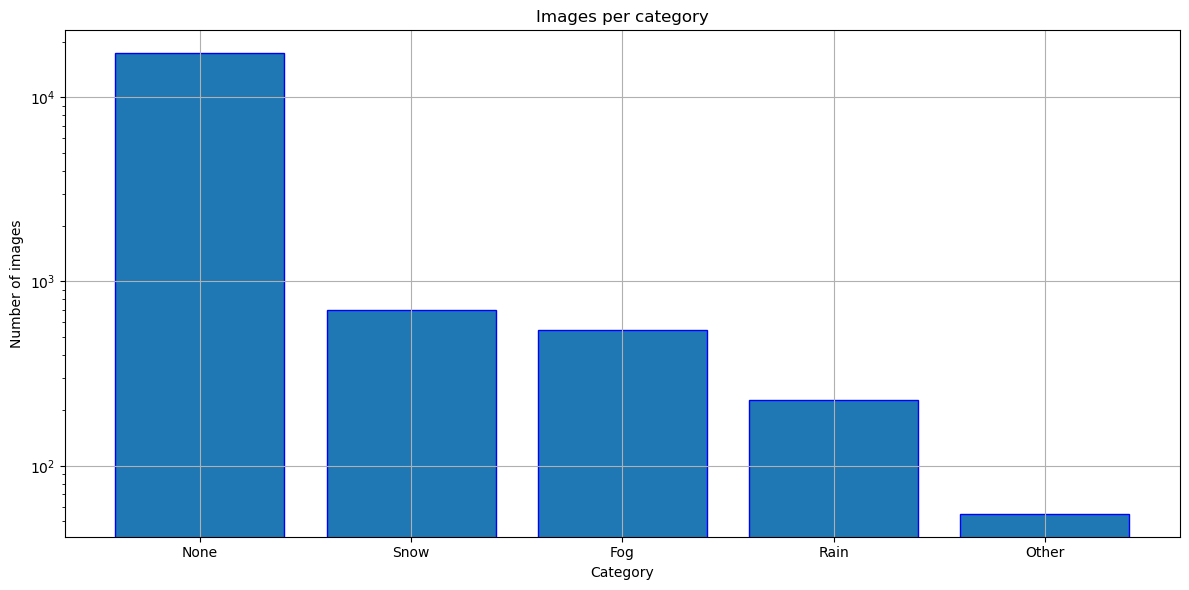

In [111]:
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100
images_per_category = pd.DataFrame(annotations.value_counts()).reset_index().rename(columns={'index':'labels', 'Weather':'Weather'})
#for im in images:
 # images_per_category[im_to_cat[im['file']]].append(im['file'])
ind = range(len(images_per_category['labels']))
plt.bar(ind, images_per_category['Weather'],edgecolor = 'b', log=True)
plt.xlabel('Category')
plt.xticks(ind, labels = ['None', 'Snow', 'Fog', 'Rain', 'Other'])
plt.ylabel('Number of images')
plt.title('Images per category')
plt.grid(b=None)
plt.tight_layout()
plt.tick_params(axis='x', which='both', bottom=True, top=False)
plt.tick_params(axis='y', which='both', right=False, left=True)
plt.show()

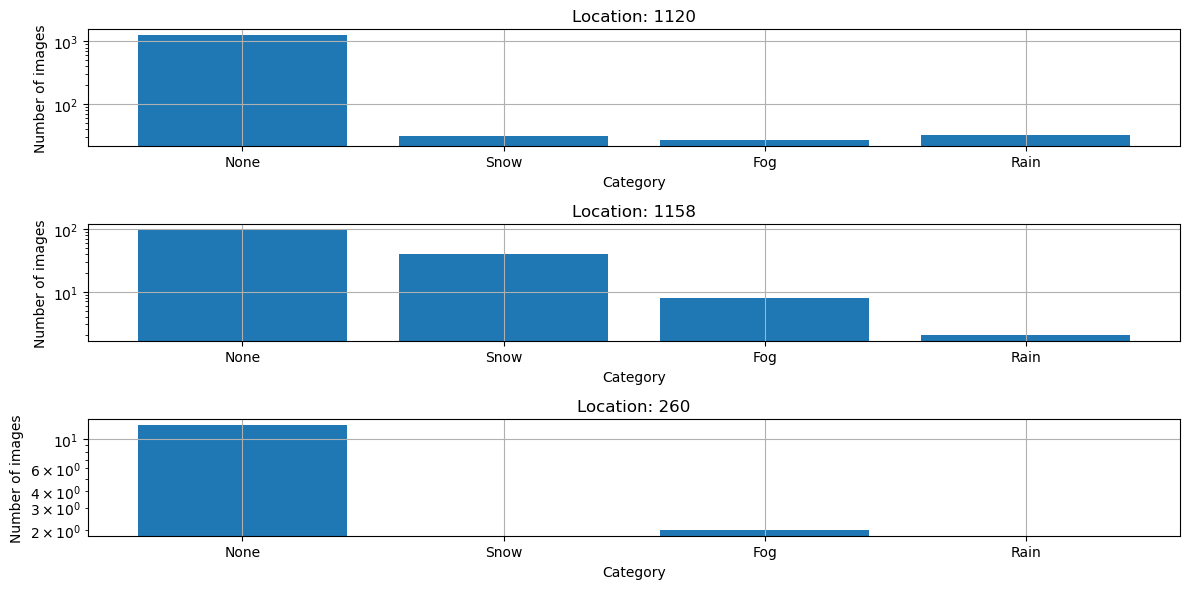

In [112]:
plt.rcParams['figure.figsize'] = [12, 6]
locs = [locations[1], locations[2], locations[3]]

images_per_category_per_loc = {}
for loc in locations:
    images_per_location = data[data['location'] == loc]
    none, Snow, Rain, Fog = sum(images_per_location['Weather'] == 'None'), \
        sum(images_per_location['Weather'] == 'Snow'), sum(images_per_location['Weather'] == 'Rain'), \
        sum(images_per_location['Weather'] == 'Fog')
    df = pd.DataFrame({'labels': ['None', 'Snow', 'Rain', 'Fog'], 'Weather':[none, Snow, Rain, Fog]})
    images_per_category_per_loc[loc] = df

ind = range(0,4)

for idx, loc in enumerate(locs):
  plt.subplot(3,1,idx+1)
  plt.bar(ind, images_per_category_per_loc[loc]['Weather'], log=True)
  plt.xlabel('Category')
  plt.ylabel('Number of images')
  plt.xticks(ind, labels = ['None', 'Snow', 'Fog', 'Rain'])
  plt.title('Location: '+str(loc))
  plt.grid(b=None)
  plt.tight_layout()
  plt.tick_params(axis='x', which='both', bottom=True, top=False)
  plt.tick_params(axis='y', which='both', right=False, left=True)
plt.show()

In [113]:
images_per_location = {loc:[] for loc in locations}

for loc in locations: 
    images_per_location1 = data[data['location'] == loc]
    number_of_images = len(images_per_location1['File'])
    images_per_location[str(loc)].append(number_of_images)
    
images_per_location['4000'] = images_per_location.pop('SNQradiometer')
images_per_location['4001'] = images_per_location.pop('SNQtower')
images_per_location['4002'] = images_per_location.pop('Wynoochee1')
images_per_location['4003'] = images_per_location.pop('Wynoochee2')
images_per_location['4004'] = images_per_location.pop('Wynoochee3')


ind = range(len(locations))
keysList = list(images_per_location.keys())
keysInt = sorted([int(x) for x in keysList])

images_per_location = pd.DataFrame.from_dict(images_per_location, orient = 'index',columns = ['values'])

plt.bar(keysInt,images_per_location['values'], width = 10, log=True)
plt.xlabel('Location')
plt.ylabel('Number of images')
plt.title('Images per location')
plt.grid(False)#b=None)
plt.tight_layout()
plt.tick_params(axis='x', which='both', bottom=True, top=False)
plt.tick_params(axis='y', which='both', right=False, left=True)
plt.show()

KeyError: 'Wynoochee1'

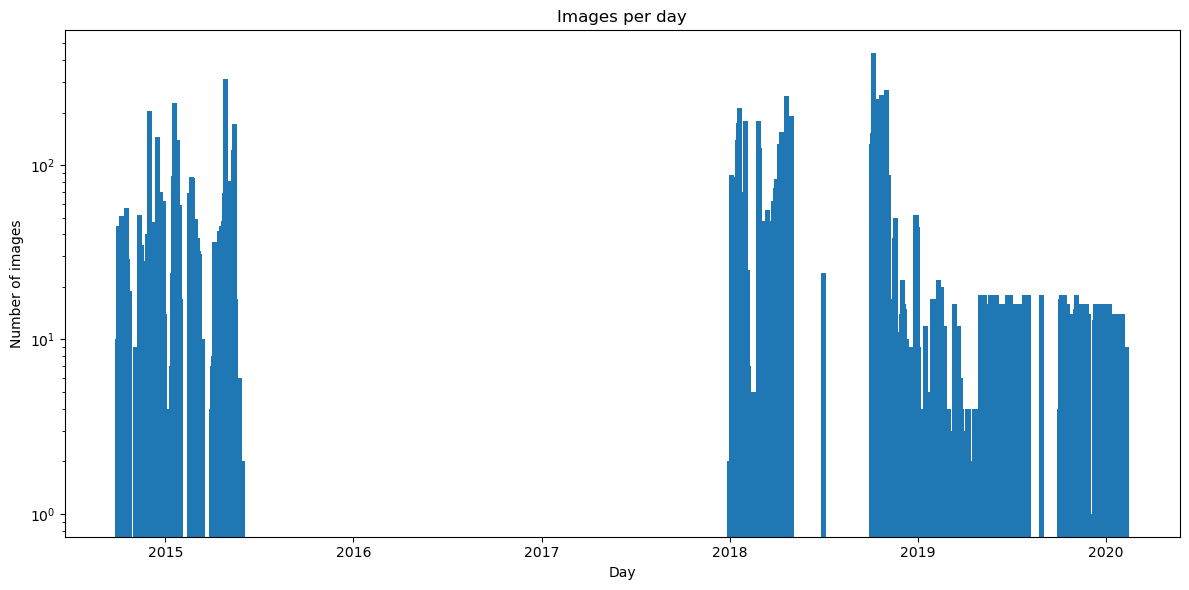

In [114]:
## images per day ## 

images_per_day = {day:[] for day in days}

for day in days: 
    images_per_day1 = data[data['Date'] == day]
    number_of_images = len(images_per_day1['File'])
    images_per_day[str(day)].append(number_of_images)

ind = range(len(days))
keysList = list(images_per_day.keys())
keysDate = sorted([pd.to_datetime(x) for x in keysList])

images_per_day = pd.DataFrame.from_dict(images_per_day, orient = 'index',columns = ['values'])

plt.bar(keysDate,images_per_day['values'], width = 10, log=True)
plt.xlabel('Day')
plt.ylabel('Number of images')
plt.title('Images per day')
plt.grid(False)#b=None)
plt.tight_layout()
plt.tick_params(axis='x', which='both', bottom=True, top=False)
plt.tick_params(axis='y', which='both', right=False, left=True)
plt.show()

## the big gap is because we have two different datasets. 2014-2015 (SNQ) and 2018-2020 (Norway)

In [115]:
images_per_day_other = {day:[] for day in days}

for day in days: 
    images_per_day1 = data[data['Date'] == day]
    images_per_day1 = data[(data['Weather'] != 'Snow') | (data['Weather'] != 'Rain')]
    number_of_images = len(images_per_day1['File'])
    images_per_day_other[str(day)].append(number_of_images)

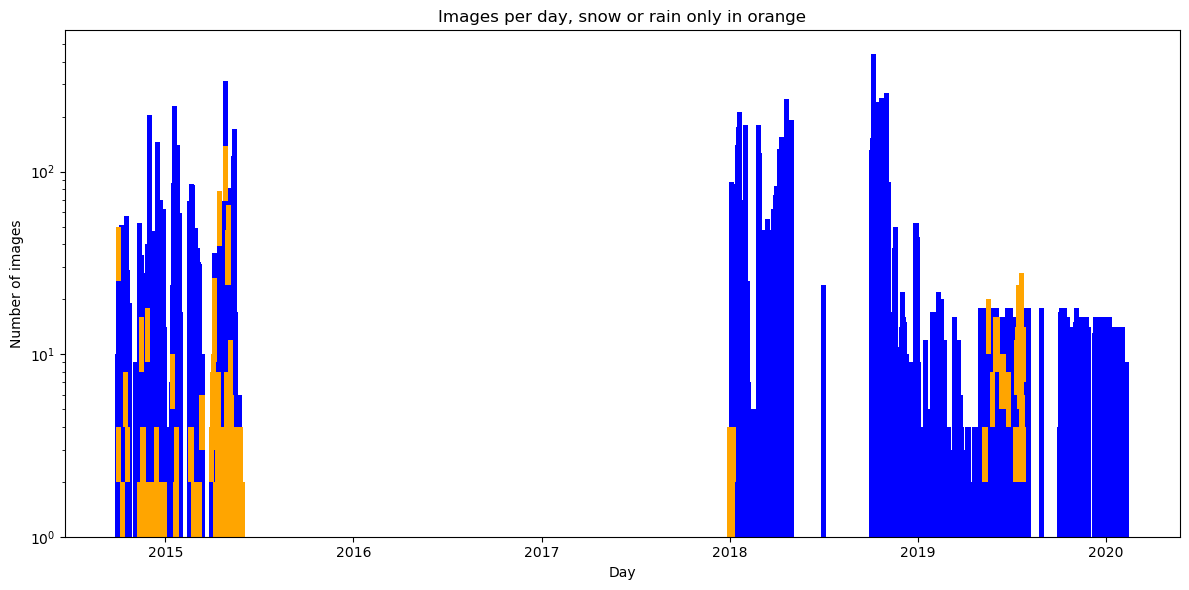

In [116]:
## weather images per day ## 
## ** filtered out for none** 

images_per_day_snow = {day:[] for day in days}
files_per_day_weather =  {file:[] for file in dataNorway} ## special step to pull just Norway image info


#### snow images (orange)
for day in days: 
    images_per_day1 = data[data['Date'] == day]
    images_per_day1 = images_per_day1[(images_per_day1['Weather'] == 'Snow')] # | (images_per_day1['Weather'] == 'Rain')]
    number_of_images = len(images_per_day1['File'])
    images_per_day_snow[str(day)].append(number_of_images)

ind = range(len(days))
keysList = list(images_per_day_snow.keys())
keysDate = sorted([pd.to_datetime(x) for x in keysList])
    
#### rain images (red)
images_per_day_rain = {day:[] for day in days}
for day in days:
    images_per_day1 = data[data['Date'] == day]
    images_per_day1 = images_per_day1[(images_per_day1['Weather'] == 'Rain')]
    number_of_images = len(images_per_day1['File'])
    images_per_day_rain[str(day)].append(number_of_images)

    
ind = range(len(days))
keysListRain = list(images_per_day_rain.keys())
keysDateRain = sorted([pd.to_datetime(x) for x in keysListRain])

#### non-weather images (blue)
images_per_day_other = {day:[] for day in days}

for day in days: 
    images_per_day1 = data[data['Date'] == day]
    images_per_day1 = images_per_day1[(images_per_day1['Weather'] != 'Snow') | (images_per_day1['Weather'] != 'Rain')]
    number_of_images = len(images_per_day1['File'])
    images_per_day_other[str(day)].append(number_of_images)
    
indOther = range(len(days))
keysListOther = list(images_per_day_other.keys())
keysDateOther = sorted([pd.to_datetime(x) for x in keysListOther])

################

images_per_day_snow = pd.DataFrame.from_dict(images_per_day_snow, orient = 'index',columns = ['values'])
images_per_day_rain = pd.DataFrame.from_dict(images_per_day_rain, orient = 'index',columns = ['values'])
images_per_day_other = pd.DataFrame.from_dict(images_per_day_other, orient = 'index',columns = ['values'])

plt.bar(keysDateOther,images_per_day_other['values'], width = 10, log=True, color = 'blue')
plt.bar(keysDate,images_per_day_snow['values'], width = 10, log=True, color='orange', bottom = images_per_day_snow['values'])
plt.xlabel('Day')
plt.ylabel('Number of images')
plt.title('Images per day, snow or rain only in orange')
plt.grid(False)#b=None)
plt.tight_layout()
plt.tick_params(axis='x', which='both', bottom=True, top=False)
plt.tick_params(axis='y', which='both', right=False, left=True)
plt.show()

## the big gap is because we have two different datasets. 2014-2015 (SNQ) and 2018-2020 (Norway)


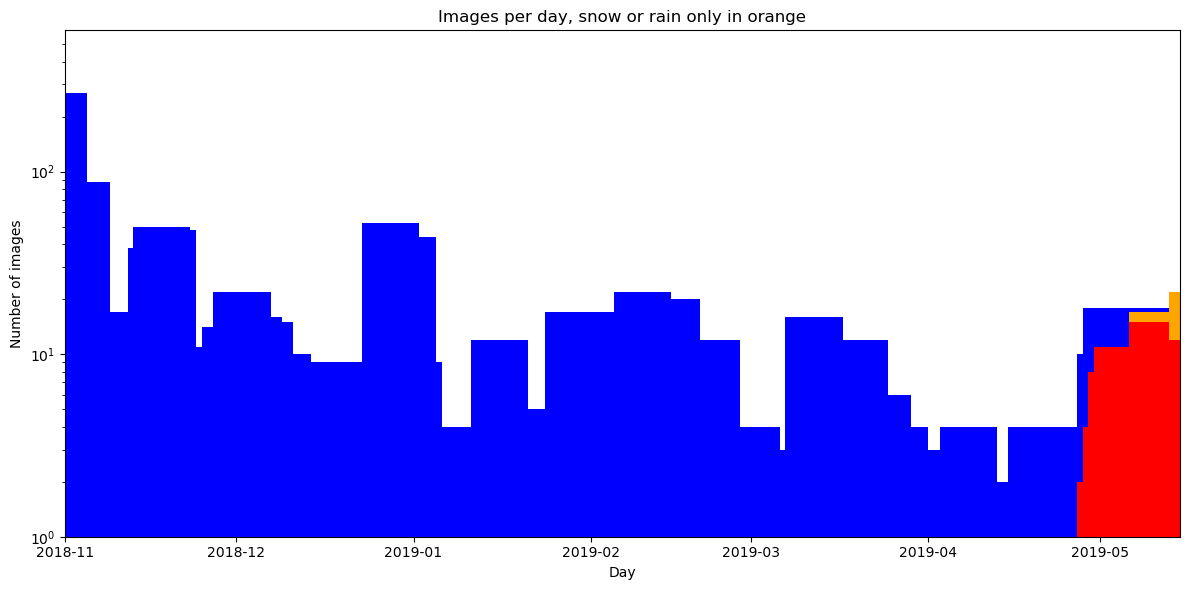

In [119]:
import datetime as dt
left = dt.date(2018,11, 1)
right = dt.date(2019, 5, 15)

plt.bar(keysDateOther,images_per_day_other['values'], width = 10, log=True, color = 'blue')
plt.bar(keysDateOther,images_per_day_rain['values'], width = 10, log=True, color = 'red', 
        bottom = images_per_day_snow['values'])
plt.bar(keysDate,images_per_day_snow['values'], width = 10, log=True, 
        color='orange', bottom = images_per_day_snow['values']+images_per_day_rain['values'])
plt.xlabel('Day')
plt.ylabel('Number of images')
plt.xlim(left, right)
plt.title('Images per day, snow or rain only in orange')
plt.grid(False)#b=None)
plt.tight_layout()
plt.tick_params(axis='x', which='both', bottom=True, top=False)
plt.tick_params(axis='y', which='both', right=False, left=True)
plt.show()

# Prompt 2: load one of your images or videos and visualize it

I have an azure account, so I will run this again on my azure account and update the paths so that everything is ready by August. 

I will visualize one example of each label: None, Rain, and Snow, Fog

In [120]:
import os
import glob #for loading images from a directory
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import random
import numpy as np
import pandas as pd
from PIL import Image
from urllib.request import urlopen
from PIL.ExifTags import TAGS 
from scipy import ndimage

In [153]:
sum(len(inputImages[key]) for key in inputImages.keys())

20

In [161]:
data[data['Weather'] == 'Snow']

Unnamed: 0                     File Weather       Date      Time  \
339           339  1119_20190530 (360).JPG    Snow  16-Jan-19   8:00:00   
340           340  1119_20190530 (423).JPG    Snow  25-Jan-19   8:00:00   
341           341  1119_20190530 (436).JPG    Snow  26-Jan-19   8:00:00   
342           342  1119_20190530 (437).JPG    Snow  27-Jan-19   8:00:00   
343           343  1119_20190530 (438).JPG    Snow  28-Jan-19   8:00:00   
...           ...                      ...     ...        ...       ...   
16867       16867  2014_11_22_10_00_00.jpg    Snow  22-Nov-14  10:00:00   
16868       16868  2014_11_22_11_00_00.jpg    Snow  22-Nov-14  11:00:00   
16869       16869  2014_11_22_11_00_00.jpg    Snow  22-Nov-14  11:00:00   
16870       16870  2014_11_22_14_01_00.jpg    Snow  22-Nov-14  14:01:00   
16871       16871  2014_11_22_14_01_00.jpg    Snow  22-Nov-14  14:01:00   

      SnowCover  Temperature       location  
339           4         -4.0           1119  
340           4         -3.0           1119  
341           4         -6.0           1119  
342           4         -5.0           1119  
343           4         -5.0           1119  
...         ...          ...            ...  
16867        na         -2.0       SNQtower  
16868        na         -2.0  SNQradiometer  
16869        na         -2.0       SNQtower  
16870        na         -3.0  SNQradiometer  
16871        na         -3.0       SNQtower  

[545 rows x 8 columns]

If we try to load in all the images in this case, the system crashes, because I am running this locally. So I am just going to pull 5 of each examples and display those. 

In [165]:
inputImages = {'snow':[], 'rain':[], 'fog':[], 'none':[], 'other':[]}


## update this as the time comes 
norwayPath = '/Volumes/CatBreen/CV4ecology/scandcam/**/*.JPG'
SNQradiometerPath = ''
SNQtowerPath = ''
####

for file in glob.glob(norwayPath, recursive=True): ## this crashes when run locally 
   # if os.path.splitext(file)[1].lower() in ('.jpg', '.jpeg'):
    filename = file.split('/')[-1]
    print(filename)
    index = data[data['File'] == filename].index
    if sum(data[data['File'] == filename].index) > 0: ## to make sure the file exists
        weather = (data['Weather'][index].values.tolist())
        print(weather)
        if sum(len(inputImages[key]) for key in inputImages.keys()) < 20:
            if (weather == ['Snow']) and (len(inputImages['snow']) < 5):
                print('snow')
                image = cv2.imread(file)
                inputImages['snow'].append(image)
            elif (weather == ['Rain']) and (len(inputImages['rain']) < 5):
                print('rain')
                image = cv2.imread(file)
                inputImages['rain'].append(image)
            elif (weather == ['None']) and (len(inputImages['none']) < 5):
                print('none')
                image = cv2.imread(file)
                inputImages['none'].append(image)
            elif (weather == ['Fog']) and (len(inputImages['fog']) < 5):
                print('fog')
                image = cv2.imread(file)
                inputImages['fog'].append(image)
            else: ## pass
                image = cv2.imread(file)
                inputImages['other'].append(image)
                print('other')
        #else: break

1119_20190530 (420).JPG
1119_20190530 (424).JPG
['Rain']
rain
1119_20190530 (425).JPG
['Rain']
rain
1119_20190530 (426).JPG
['Rain']
rain
1119_20190530 (427).JPG
['Rain']
rain
1119_20190530 (428).JPG
['Rain']
rain
1119_20190530 (429).JPG
['Rain']
other
1119_20190530 (430).JPG
['Rain']
other
1119_20190530 (431).JPG
['Rain']
other
1119_20190530 (432).JPG
['Rain']
other
1119_20190530 (433).JPG
['Rain']
other
1119_20190530 (434).JPG
['Rain']
other
1119_20190530 (435).JPG
['Rain']
other
1119_20190530 (452).JPG
['Rain']
other
1119_20190530 (453).JPG
['Rain']
other
1119_20190530 (454).JPG
['Rain']
other
1119_20190530 (51).JPG
['Rain']
other
1120_20190723 (135).JPG
['Rain']
other
1120_20190723 (1508).JPG
['Rain']
other
1120_20190723 (1509).JPG
['Rain']
other
1120_20190723 (1510).JPG
['Rain']
other
1120_20190723 (238).JPG
['Rain']
1158_20180624 (2053).JPG
['Rain', 'Rain']
1158_20180624 (2063).JPG
['Rain', 'Rain']
260_20180622 (10).JPG
['Rain', 'Rain']
328_20180731 (196).JPG
['Rain']
334_2018101

['Rain', 'Rain']
1911_20190719 (429).JPG
['Rain', 'Rain']
1911_20190719 (457).JPG
['Rain', 'Rain']
1911_20190719 (419).JPG
['Rain']
1911_20190719 (420).JPG
['Rain']
1911_20190719 (421).JPG
['Rain']
1911_20190719 (425).JPG
['Rain']
1911_20190719 (430).JPG
['Rain', 'Rain']
1911_20190719 (465).JPG
['Rain', 'Rain']
1911_20190719 (466).JPG
['Rain', 'Rain']
1911_20190719 (467).JPG
['Rain', 'Rain']
1911_20190719 (468).JPG
['Rain', 'Rain']
1911_20190719 (469).JPG
['Rain', 'Rain']
1911_20190719 (470).JPG
['Rain', 'Rain']
1911_20190719 (471).JPG
['Rain', 'Rain']
1911_20190719 (472).JPG
['Rain', 'Rain']
1911_20190719 (473).JPG
['Rain', 'Rain']
1911_20190719 (474).JPG
['Rain', 'Rain']
3060_20191124 (119).JPG
['Rain']
361_20190530 (161).JPG
['Rain']
361_20190530 (162).JPG
['Rain']
361_20190530 (163).JPG
['Rain']
361_20190530 (164).JPG
['Rain']
361_20190530 (165).JPG
['Rain']
361_20190530 (166).JPG
['Rain']
397_20180117 (883).JPG
['Rain']
361_20190530 (167).JPG
['Rain']
361_20190530 (168).JPG
['Rain

['Snow']
611_20180406 (98).JPG
['Snow']
611_20180406 (99).JPG
['Snow']
615_20180626 (31).JPG
['Snow']
615_20180626 (32).JPG
['Snow']
615_20180626 (33).JPG
['Snow']
646_20180620 (2051).JPG
['Snow']
675_20180518 (363).JPG
['Snow']
688_20180508 (32).JPG
['Snow', 'Snow']
750_20180508 (170).JPG
['Snow']
750_20180508 (171).JPG
['Snow']
750_20180508 (172).JPG
['Snow']
750_20180508 (173).JPG
['Snow']
760_20190719 (22).JPG
['Snow']
869_20180626 (10).JPG
['Snow', 'Snow']
938_20190710 (274).JPG
['Snow']
938_20190710 (275).JPG
['Snow']
938_20190710 (276).JPG
['Snow']
938_20190710 (578).JPG
['Snow']
938_20190710 (579).JPG
['Snow']
938_20190710 (580).JPG
['Snow']
938_20190710 (581).JPG
['Snow']
938_20190710 (582).JPG
['Snow']
938_20190710 (583).JPG
['Snow']
938_20190710 (584).JPG
['Snow']
938_20190710 (585).JPG
['Snow']
938_20190710 (586).JPG
['Snow']
938_20190710 (587).JPG
['Snow']
411_20180518 (116).JPG
['Snow']
488_20180601 (209).JPG
['Snow']
546_20180419 (30).JPG
['Snow']
548_20180601 (119).JPG


['Fog']
670_20180513 (21).JPG
['Fog']
688_20180508 (35).JPG
['Fog']
690_20180508 (56).JPG
['Fog']
717_20180724 (30).JPG
['Fog']
717_20180724 (45).JPG
['Fog']
717_20180724 (48).JPG
['Fog']
717_20180724 (54).JPG
['Fog']
717_20180724 (59).JPG
['Fog']
717_20180724 (77).JPG
['Fog']
717_20180724 (83).JPG
['Fog']
728_20180601 (80).JPG
['Fog']
739_20180625 (10).JPG
['Fog']
760_20190719 (11).JPG
['Fog']
760_20190719 (12).JPG
['Fog']
892_20181026 (558).JPG
['Fog']
938_20190710 (113).JPG
['Fog']
938_20190710 (182).JPG
['Fog']
938_20190710 (462).JPG
['Fog']
938_20190710 (463).JPG
['Fog']
938_20190710 (464).JPG
['Fog']
938_20190710 (465).JPG
['Fog']
938_20190710 (466).JPG
['Fog']
938_20190710 (467).JPG
['Fog']
938_20190710 (468).JPG
['Fog']
938_20190710 (469).JPG
['Fog']
938_20190710 (470).JPG
['Fog']
938_20190710 (471).JPG
['Fog']
938_20190710 (472).JPG
['Fog']
938_20190710 (473).JPG
['Fog']
938_20190710 (474).JPG
['Fog']
938_20190710 (475).JPG
['Fog']
938_20190710 (476).JPG
['Fog']
938_20190710 (

['None']
1119_20190530 (205).JPG
['None']
1119_20190530 (206).JPG
['None']
1119_20190530 (207).JPG
['None']
1119_20190530 (208).JPG
['None']
1119_20190530 (209).JPG
['None']
1119_20190530 (210).JPG
['None']
1119_20190530 (211).JPG
['None']
1119_20190530 (212).JPG
['None']
1119_20190530 (213).JPG
['None']
1119_20190530 (214).JPG
['None']
1119_20190530 (215).JPG
['None']
1119_20190530 (216).JPG
['None']
1119_20190530 (217).JPG
['None']
1119_20190530 (218).JPG
['None']
1119_20190530 (219).JPG
['None']
1119_20190530 (220).JPG
['None']
1119_20190530 (221).JPG
['None']
1119_20190530 (222).JPG
['None']
1119_20190530 (223).JPG
['None']
1119_20190530 (224).JPG
['None']
1119_20190530 (225).JPG
['None']
1119_20190530 (226).JPG
['None']
1119_20190530 (227).JPG
['None']
1119_20190530 (228).JPG
['None']
1119_20190530 (229).JPG
['None']
1119_20190530 (230).JPG
['None']
1119_20190530 (231).JPG
['None']
1119_20190530 (232).JPG
['None']
1119_20190530 (233).JPG
['None']
1119_20190530 (234).JPG
['None']
1

['None']
1119_20190530 (486).JPG
['None']
1119_20190530 (487).JPG
['None']
1119_20190530 (488).JPG
['None']
1119_20190530 (489).JPG
['None']
1119_20190530 (49).JPG
['None']
1119_20190530 (490).JPG
['None']
1119_20190530 (491).JPG
['None']
1119_20190530 (492).JPG
['None']
1119_20190530 (514).JPG
['None']
1119_20190530 (516).JPG
['None']
1119_20190530 (517).JPG
['None']
1119_20190530 (518).JPG
['None']
1119_20190530 (519).JPG
['None']
1119_20190530 (520).JPG
['None']
1119_20190530 (521).JPG
['None']
1119_20190530 (522).JPG
['None']
1119_20190530 (523).JPG
['None']
1119_20190530 (524).JPG
['None']
1119_20190530 (527).JPG
['None']
1119_20190530 (528).JPG
['None']
1119_20190530 (529).JPG
['None']
1119_20190530 (530).JPG
['None']
1119_20190530 (532).JPG
['None']
1119_20190530 (533).JPG
['None']
1119_20190530 (534).JPG
['None']
1119_20190530 (535).JPG
['None']
1119_20190530 (536).JPG
['None']
1119_20190530 (537).JPG
['None']
1119_20190530 (538).JPG
['None']
1119_20190530 (539).JPG
['None']
11

['None']
1119_20190530 (841).JPG
['None']
1119_20190530 (842).JPG
['None']
1119_20190530 (843).JPG
['None']
1119_20190530 (844).JPG
['None']
1119_20190530 (845).JPG
['None']
1119_20190530 (846).JPG
['None']
1119_20190530 (847).JPG
['None']
1119_20190530 (848).JPG
['None']
1119_20190530 (849).JPG
['None']
1119_20190530 (85).JPG
['None']
1119_20190530 (850).JPG
['None']
1119_20190530 (851).JPG
['None']
1119_20190530 (852).JPG
['None']
1119_20190530 (853).JPG
['None']
1119_20190530 (854).JPG
['None']
1119_20190530 (855).JPG
['None']
1119_20190530 (856).JPG
['None']
1119_20190530 (857).JPG
['None']
1119_20190530 (858).JPG
['None']
1119_20190530 (859).JPG
['None']
1119_20190530 (86).JPG
['None']
1119_20190530 (860).JPG
['None']
1119_20190530 (861).JPG
['None']
1119_20190530 (862).JPG
['None']
1119_20190530 (863).JPG
['None']
1119_20190530 (864).JPG
['None']
1119_20190530 (865).JPG
['None']
1119_20190530 (866).JPG
['None']
1119_20190530 (867).JPG
['None']
1119_20190530 (868).JPG
['None']
111

['None']
1120_20190723 (1097).JPG
['None']
1120_20190723 (1098).JPG
['None']
1120_20190723 (1099).JPG
['None']
1120_20190723 (1100).JPG
['None']
1120_20190723 (1101).JPG
['None']
1120_20190723 (1102).JPG
['None']
1120_20190723 (1103).JPG
['None']
1120_20190723 (1104).JPG
['None']
1120_20190723 (1105).JPG
['None']
1120_20190723 (1106).JPG
['None']
1120_20190723 (1107).JPG
['None']
1120_20190723 (1108).JPG
['None']
1120_20190723 (1109).JPG
['None']
1120_20190723 (1110).JPG
['None']
1120_20190723 (1111).JPG
['None']
1120_20190723 (1112).JPG
['None']
1120_20190723 (1120).JPG
['None']
1120_20190723 (1121).JPG
['None']
1120_20190723 (1122).JPG
['None']
1120_20190723 (1123).JPG
['None']
1120_20190723 (1124).JPG
['None']
1120_20190723 (1149).JPG
['None']
1120_20190723 (1150).JPG
['None']
1120_20190723 (1151).JPG
['None']
1120_20190723 (1152).JPG
['None']
1120_20190723 (1153).JPG
['None']
1120_20190723 (1154).JPG
['None']
1120_20190723 (1155).JPG
['None']
1120_20190723 (1156).JPG
['None']
1120_

['None']
1120_20190723 (1403).JPG
['None']
1120_20190723 (1404).JPG
['None']
1120_20190723 (1405).JPG
['None']
1120_20190723 (1406).JPG
['None']
1120_20190723 (1407).JPG
['None']
1120_20190723 (1408).JPG
['None']
1120_20190723 (1409).JPG
['None']
1120_20190723 (1410).JPG
['None']
1120_20190723 (1411).JPG
['None']
1120_20190723 (1412).JPG
['None']
1120_20190723 (1413).JPG
['None']
1120_20190723 (1414).JPG
['None']
1120_20190723 (1415).JPG
['None']
1120_20190723 (1416).JPG
['None']
1120_20190723 (1417).JPG
['None']
1120_20190723 (1418).JPG
['None']
1120_20190723 (1419).JPG
['None']
1120_20190723 (1420).JPG
['None']
1120_20190723 (1421).JPG
['None']
1120_20190723 (1422).JPG
['None']
1120_20190723 (1423).JPG
['None']
1120_20190723 (1424).JPG
['None']
1120_20190723 (1425).JPG
['None']
1120_20190723 (1469).JPG
['None']
1120_20190723 (1470).JPG
['None']
1120_20190723 (1471).JPG
['None']
1120_20190723 (1472).JPG
['None']
1120_20190723 (1473).JPG
['None']
1120_20190723 (1474).JPG
['None']
1120_

['None']
1120_20190723 (1729).JPG
['None']
1120_20190723 (1730).JPG
['None']
1120_20190723 (1731).JPG
['None']
1120_20190723 (1732).JPG
['None']
1120_20190723 (1733).JPG
['None']
1120_20190723 (1734).JPG
['None']
1120_20190723 (1735).JPG
['None']
1120_20190723 (1736).JPG
['None']
1120_20190723 (1737).JPG
['None']
1120_20190723 (1738).JPG
['None']
1120_20190723 (1739).JPG
['None']
1120_20190723 (1740).JPG
['None']
1120_20190723 (1741).JPG
['None']
1120_20190723 (1742).JPG
['None']
1120_20190723 (1743).JPG
['None', 'None']
1120_20190723 (1744).JPG
['None', 'None']
1120_20190723 (1745).JPG
['None', 'None']
1120_20190723 (1746).JPG
['None', 'None']
1120_20190723 (1747).JPG
['None', 'None']
1120_20190723 (1748).JPG
['None', 'None']
1120_20190723 (1749).JPG
['None', 'None']
1120_20190723 (1750).JPG
['None', 'None']
1120_20190723 (1751).JPG
['None', 'None']
1120_20190723 (1752).JPG
['None', 'None']
1120_20190723 (1753).JPG
['None', 'None']
1120_20190723 (1754).JPG
['None', 'None']
1120_201907

['None']
1120_20190723 (533).JPG
['None']
1120_20190723 (534).JPG
['None']
1120_20190723 (535).JPG
['None']
1120_20190723 (536).JPG
['None']
1120_20190723 (537).JPG
['None']
1120_20190723 (538).JPG
['None']
1120_20190723 (539).JPG
['None']
1120_20190723 (540).JPG
['None']
1120_20190723 (541).JPG
['None']
1120_20190723 (542).JPG
['None']
1120_20190723 (543).JPG
['None']
1120_20190723 (544).JPG
['None']
1120_20190723 (545).JPG
['None']
1120_20190723 (546).JPG
['None']
1120_20190723 (547).JPG
['None']
1120_20190723 (548).JPG
['None']
1120_20190723 (549).JPG
['None']
1120_20190723 (550).JPG
['None']
1120_20190723 (551).JPG
['None']
1120_20190723 (552).JPG
['None']
1120_20190723 (553).JPG
['None']
1120_20190723 (554).JPG
['None']
1120_20190723 (557).JPG
['None']
1120_20190723 (558).JPG
['None']
1120_20190723 (559).JPG
['None']
1120_20190723 (560).JPG
['None']
1120_20190723 (561).JPG
['None']
1120_20190723 (562).JPG
['None']
1120_20190723 (563).JPG
['None']
1120_20190723 (564).JPG
['None']
1

['None']
1120_20190723 (893).JPG
['None']
1120_20190723 (894).JPG
['None']
1120_20190723 (895).JPG
['None']
1120_20190723 (896).JPG
['None']
1120_20190723 (897).JPG
['None']
1120_20190723 (898).JPG
['None']
1120_20190723 (899).JPG
['None']
1120_20190723 (900).JPG
['None']
1120_20190723 (901).JPG
['None']
1120_20190723 (902).JPG
['None']
1120_20190723 (903).JPG
['None']
1120_20190723 (904).JPG
['None']
1120_20190723 (905).JPG
['None']
1120_20190723 (906).JPG
['None']
1120_20190723 (907).JPG
['None']
1120_20190723 (908).JPG
['None']
1120_20190723 (909).JPG
['None']
1120_20190723 (91).JPG
['None']
1120_20190723 (910).JPG
['None']
1120_20190723 (911).JPG
['None']
1120_20190723 (912).JPG
['None']
1120_20190723 (913).JPG
['None']
1120_20190723 (914).JPG
['None']
1120_20190723 (915).JPG
['None']
1120_20190723 (916).JPG
['None']
1120_20190723 (917).JPG
['None']
1120_20190723 (918).JPG
['None']
1120_20190723 (919).JPG
['None']
1120_20190723 (920).JPG
['None']
1120_20190723 (921).JPG
['None']
11

['None']
269_20180527 (2).JPG
['None']
269_20180527 (4).JPG
['None']
269_20180527 (8).JPG
['None']
270_20180527 (10).JPG
['None']
270_20180527 (13).JPG
['None']
270_20180527 (14).JPG
['None']
270_20180527 (17).JPG
['None']
270_20180527 (8).JPG
['None']
273_20180507 (15).JPG
['None']
273_20180507 (16).JPG
['None']
273_20180507 (19).JPG
['None']
274_20180507 (10).JPG
['None']
274_20180507 (100).JPG
['None']
274_20180507 (101).JPG
['None']
275_20180420 (13).JPG
['None']
275_20180420 (15).JPG
['None']
275_20180420 (18).JPG
['None']
275_20180420 (19).JPG
['None']
275_20180420 (22).JPG
['None']
275_20170117 (31).JPG
['None']
275_20170117 (36).JPG
['None']
275_20170117 (59).JPG
['None']
276_20181019 (1536).JPG
['None']
276_20181019 (1537).JPG
['None']
278_20181019 (1428).JPG
['None']
278_20181019 (1429).JPG
['None']
280_20181017 (479).JPG
['None']
280_20181017 (480).JPG
['None']
281_20181017 (260).JPG
['None']
281_20181017 (261).JPG
['None']
282_20181016 (311).JPG
['None']
282_20181016 (312).

['None']
341_20180325 (86).JPG
['None']
341_20180325 (87).JPG
['None']
341_20180325 (88).JPG
['None']
341_20180325 (89).JPG
['None']
341_20180325 (92).JPG
['None']
341_20180325 (99).JPG
['None']
345_20181018 (416).JPG
['None']
345_20181018 (417).JPG
['None']
345_20180611 (1272).JPG
['None']
345_20180611 (1892).JPG
['None']
345_20180611 (2100).JPG
['None']
345_20180611 (83).JPG
['None']
351_20181018 (451).JPG
['None']
351_20181018 (452).JPG
['None']
395_20180720 (511).JPG
['None']
395_20180720 (515).JPG
['None']
395_20180720 (518).JPG
['None']
396_20180531 (118).JPG
['None']
396_20180531 (119).JPG
['None']
396_20180408  (1335).JPG
['None']
396_20180408  (1336).JPG
['None']
396_20180408  (1349).JPG
['None']
396_20180408  (1461).JPG
['None']
396_20180408  (1475).JPG
['None']
396_20180408  (1986).JPG
['None']
396_20180408  (1999).JPG
['None']
396_20180408  (2388).JPG
['None']
396_20180408  (2395).JPG
['None']
396_20180408  (2626).JPG
['None']
396_20180408  (2694).JPG
['None']
396_20180408 

['None']
520_20190415 (17).JPG
['None']
520_20190415 (18).JPG
['None']
520_20190415 (19).JPG
['None']
520_20190415 (193).JPG
['None']
520_20190415 (20).JPG
['None']
520_20190415 (21).JPG
['None']
520_20190415 (22).JPG
['None']
520_20190415 (220).JPG
['None']
520_20190415 (221).JPG
['None']
520_20190415 (222).JPG
['None']
520_20190415 (223).JPG
['None']
520_20190415 (224).JPG
['None']
520_20190415 (225).JPG
['None']
520_20190415 (226).JPG
['None']
520_20190415 (227).JPG
['None']
520_20190415 (228).JPG
['None']
520_20190415 (229).JPG
['None']
520_20190415 (23).JPG
['None']
520_20190415 (230).JPG
['None']
520_20190415 (231).JPG
['None']
520_20190415 (232).JPG
['None']
520_20190415 (233).JPG
['None']
520_20190415 (234).JPG
['None']
520_20190415 (235).JPG
['None']
520_20190415 (236).JPG
['None']
520_20190415 (237).JPG
['None']
520_20190415 (238).JPG
['None']
520_20190415 (239).JPG
['None']
520_20190415 (24).JPG
['None']
520_20190415 (240).JPG
['None']
520_20190415 (241).JPG
['None']
520_201

['None']
520_20190415 (490).JPG
['None']
520_20190415 (491).JPG
['None']
520_20190415 (492).JPG
['None']
520_20190415 (493).JPG
['None']
520_20190415 (494).JPG
['None']
520_20190415 (495).JPG
['None']
520_20190415 (496).JPG
['None']
520_20190415 (497).JPG
['None']
520_20190415 (498).JPG
['None']
520_20190415 (499).JPG
['None']
520_20190415 (5).JPG
['None']
520_20190415 (500).JPG
['None']
520_20190415 (501).JPG
['None']
520_20190415 (502).JPG
['None']
520_20190415 (503).JPG
['None']
520_20190415 (504).JPG
['None']
520_20190415 (505).JPG
['None']
520_20190415 (506).JPG
['None']
520_20190415 (507).JPG
['None']
520_20190415 (508).JPG
['None']
520_20190415 (509).JPG
['None']
520_20190415 (510).JPG
['None']
520_20190415 (511).JPG
['None']
520_20190415 (512).JPG
['None']
520_20190415 (513).JPG
['None']
520_20190415 (514).JPG
['None']
520_20190415 (515).JPG
['None']
520_20190415 (516).JPG
['None']
520_20190415 (517).JPG
['None']
520_20190415 (518).JPG
['None']
520_20190415 (519).JPG
['None']
5

['None']
531_20190719 (106).JPG
['None']
531_20190719 (107).JPG
['None']
531_20190719 (108).JPG
['None']
531_20190719 (109).JPG
['None']
531_20190719 (11).JPG
['None']
531_20190719 (110).JPG
['None']
531_20190719 (111).JPG
['None']
531_20190719 (112).JPG
['None']
54_20180424 (189).JPG
['None']
531_20190719 (114).JPG
['None']
54_20180424 (190).JPG
['None']
531_20190719 (116).JPG
['None']
531_20190719 (117).JPG
['None']
531_20190719 (118).JPG
['None']
531_20190719 (119).JPG
['None']
531_20190719 (12).JPG
['None']
531_20190719 (120).JPG
['None']
531_20190719 (121).JPG
['None']
531_20190719 (122).JPG
['None']
531_20190719 (123).JPG
['None']
531_20190719 (124).JPG
['None']
531_20190719 (125).JPG
['None']
531_20190719 (126).JPG
['None']
531_20190719 (127).JPG
['None']
531_20190719 (128).JPG
['None']
531_20190719 (129).JPG
['None']
531_20190719 (13).JPG
['None']
531_20190719 (130).JPG
['None']
531_20190719 (131).JPG
['None']
531_20190719 (132).JPG
['None']
531_20190719 (133).JPG
['None']
531_

['None']
552_20180730 (27).JPG
['None']
552_20180730 (29).JPG
['None']
552_20180730 (51).JPG
['None']
555_20180615 (1).JPG
['None', 'None']
555_20180615 (11).JPG
['None']
555_20180615 (12).JPG
['None']
555_20180615 (13).JPG
['None']
555_20180615 (16).JPG
['None']
555_20180615 (18).JPG
['None']
555_20180615 (2).JPG
['None', 'None']
555_20180615 (28).JPG
['None']
555_20180615 (36).JPG
['None']
555_20180615 (40).JPG
['None']
555_20180615 (5).JPG
['None']
54_20180424 (198).JPG
['None']
54_20180424 (199).JPG
['None']
54_20180424 (200).JPG
['None']
54_20180424 (201).JPG
['None']
117_20181205 (185).JPG
['None']
117_20181205 (186).JPG
['None']
563_20180422 (25).JPG
['None']
563_20180422 (26).JPG
['None']
563_20180422 (29).JPG
['None']
563_20180422 (31).JPG
['None']
563_20180422 (34).JPG
['None']
563_20180422 (38).JPG
['None']
563_20180422 (40).JPG
['None']
563_20180422 (44).JPG
['None']
564_20180602 (103).JPG
['None']
564_20180602 (107).JPG
['None']
564_20180602 (31).JPG
['None']
564_20180602 

['None']
617_20180504 (21).JPG
['None']
617_20180504 (34).JPG
['None']
617_20180504 (36).JPG
['None']
617_20180504 (40).JPG
['None']
617_20180504 (5).JPG
['None']
617_20180504 (7).JPG
['None']
617_20180504 (8).JPG
['None']
618_20181031 (1000).JPG
['None']
618_20181031 (1001).JPG
['None']
618_20180626 (1).JPG
['None']
618_20180626 (102).JPG
['None']
618_20180626 (172).JPG
['None']
618_20180626 (177).JPG
['None']
618_20180626 (187).JPG
['None']
618_20180626 (2).JPG
['None']
618_20180626 (35).JPG
['None']
618_20180626 (71).JPG
['None']
618_20180626 (72).JPG
['None']
618_20180626 (73).JPG
['None']
618_20180626 (74).JPG
['None']
618_20180626 (80).JPG
['None']
618_20180626 (91).JPG
['None']
621_20180412 (100).JPG
['None']
621_20180412 (103).JPG
['None', 'None']
621_20180412 (104).JPG
['None']
621_20180412 (105).JPG
['None']
621_20180412 (127).JPG
['None']
621_20180412 (135).JPG
['None']
621_20180412 (145).JPG
['None']
621_20180412 (86).JPG
['None']
621_20180412 (88).JPG
['None']
621_20180412

['None']
671_20180513 (11).JPG
['None']
671_20180513 (14).JPG
['None']
671_20180513 (15).JPG
['None']
671_20180513 (16).JPG
['None']
671_20180513 (19).JPG
['None']
671_20180513 (21).JPG
['None']
671_20180513 (28).JPG
['None']
671_20180513 (30).JPG
['None']
671_20180513 (34).JPG
['None']
671_20180513 (5).JPG
['None']
671_20180513 (7).JPG
['None']
671_20180513 (8).JPG
['None']
672_20180510 (1).JPG
['None']
672_20180510 (10).JPG
['None']
672_20180510 (3).JPG
['None']
672_20180510 (35).JPG
['None']
672_20180510 (7).JPG
['None']
675_20181021 (365).JPG
['None']
675_20181021 (366).JPG
['None']
675_20180518 (12).JPG
['None']
675_20180518 (13).JPG
['None']
675_20180518 (143).JPG
['None']
675_20180518 (166).JPG
['None']
675_20180518 (20).JPG
['None']
675_20180518 (234).JPG
['None']
675_20180518 (253).JPG
['None']
675_20180518 (364).JPG
['None']
675_20180518 (379).JPG
['None']
675_20180518 (384).JPG
['None']
675_20180518 (400).JPG
['None']
675_20180518 (410).JPG
['None']
675_20180518 (440).JPG
['

['None']
750_20180508 (141).JPG
['None']
750_20180508 (157).JPG
['None']
750_20180508 (167).JPG
['None']
750_20180508 (168).JPG
['None']
750_20180508 (169).JPG
['None']
750_20180508 (209).JPG
['None']
750_20180508 (250).JPG
['None']
750_20180508 (374).JPG
['None']
750_20180508 (403).JPG
['None']
750_20180508 (431).JPG
['None']
750_20180508 (47).JPG
['None']
750_20180508 (81).JPG
['None']
756_20180610 (13).JPG
['None']
756_20180610 (17).JPG
['None']
756_20180610 (20).JPG
['None']
756_20180610 (54).JPG
['None']
757_20180616 (101).JPG
['None']
757_20180616 (105).JPG
['None']
757_20180616 (53).JPG
['None']
757_20180616 (54).JPG
['None']
757_20180616 (57).JPG
['None']
757_20180616 (59).JPG
['None']
757_20180616 (60).JPG
['None']
757_20180616 (66).JPG
['None']
757_20180616 (67).JPG
['None']
757_20180616 (68).JPG
['None']
757_20180616 (71).JPG
['None']
757_20180616 (73).JPG
['None']
757_20180616 (80).JPG
['None']
757_20180616 (82).JPG
['None']
757_20180616 (86).JPG
['None']
759_20181023 (177)

['None']
879_20180527 (30).JPG
['None']
879_20180527 (31).JPG
['None']
879_20180527 (34).JPG
['None']
879_20180527 (36).JPG
['None']
879_20180527 (46).JPG
['None']
879_20180527 (48).JPG
['None']
879_20180527 (52).JPG
['None']
885_20181024 (115).JPG
['None']
885_20181024 (116).JPG
['None']
885_20180623 (21).JPG
['None']
885_20180623 (29).JPG
['None']
885_20180623 (3).JPG
['None']
885_20180623 (39).JPG
['None']
885_20180623 (5).JPG
['None']
886_20180528 (10).JPG
['None']
886_20180528 (84).JPG
['None']
887_20180528 (10).JPG
['None', 'None']
887_20180528 (100).JPG
['None']
888_20180528 (16).JPG
['None']
888_20180528 (45).JPG
['None']
888_20180528 (46).JPG
['None']
889_20180528 (10).JPG
['None', 'None']
889_20180528 (100).JPG
['None']
890_20180525 (31).JPG
['None']
890_20180525 (32).JPG
['None']
891_20180622 (10).JPG
['None']
891_20180622 (100).JPG
['None']
892_20181026 (559).JPG
['None']
893_20180424 (56).JPG
['None']
893_20180424 (60).JPG
['None']
893_20180424 (63).JPG
['None']
893_201804

['None']
902_20190802 (1190).JPG
['None']
902_20190802 (1191).JPG
['None']
902_20190802 (1192).JPG
['None']
902_20190802 (1193).JPG
['None']
902_20190802 (1194).JPG
['None']
902_20190802 (1195).JPG
['None']
902_20190802 (1196).JPG
['None']
902_20190802 (1197).JPG
['None']
902_20190802 (1198).JPG
['None']
902_20190802 (1199).JPG
['None']
902_20190802 (12).JPG
['None']
902_20190802 (120).JPG
['None']
902_20190802 (1200).JPG
['None']
902_20190802 (1201).JPG
['None']
902_20190802 (1202).JPG
['None']
902_20190802 (1203).JPG
['None']
902_20190802 (1204).JPG
['None']
902_20190802 (1205).JPG
['None']
902_20190802 (1206).JPG
['None']
902_20190802 (1207).JPG
['None']
902_20190802 (1208).JPG
['None']
902_20190802 (1209).JPG
['None']
902_20190802 (121).JPG
['None']
902_20190802 (1210).JPG
['None']
902_20190802 (1211).JPG
['None']
902_20190802 (1212).JPG
['None']
902_20190802 (1213).JPG
['None']
902_20190802 (1214).JPG
['None']
902_20190802 (1215).JPG
['None']
902_20190802 (1216).JPG
['None']
902_2

['None']
902_20190802 (1424).JPG
['None']
902_20190802 (1425).JPG
['None']
902_20190802 (1426).JPG
['None']
902_20190802 (1427).JPG
['None']
902_20190802 (1428).JPG
['None']
902_20190802 (1429).JPG
['None']
902_20190802 (143).JPG
['None']
902_20190802 (1430).JPG
['None']
902_20190802 (1431).JPG
['None']
902_20190802 (1432).JPG
['None']
902_20190802 (1433).JPG
['None']
902_20190802 (1434).JPG
['None']
902_20190802 (1435).JPG
['None']
902_20190802 (1436).JPG
['None']
902_20190802 (1437).JPG
['None']
902_20190802 (1438).JPG
['None']
902_20190802 (1439).JPG
['None']
902_20190802 (144).JPG
['None']
902_20190802 (1440).JPG
['None']
902_20190802 (1441).JPG
['None']
902_20190802 (1442).JPG
['None']
902_20190802 (1443).JPG
['None']
902_20190802 (1444).JPG
['None']
902_20190802 (1445).JPG
['None']
902_20190802 (1446).JPG
['None']
902_20190802 (1447).JPG
['None']
902_20190802 (1448).JPG
['None']
902_20190802 (1449).JPG
['None']
902_20190802 (145).JPG
['None']
902_20190802 (1450).JPG
['None']
902_

['None']
902_20190802 (1677).JPG
['None']
902_20190802 (1678).JPG
['None']
902_20190802 (1679).JPG
['None']
902_20190802 (168).JPG
['None']
902_20190802 (1680).JPG
['None']
902_20190802 (1681).JPG
['None']
902_20190802 (1682).JPG
['None']
902_20190802 (1683).JPG
['None']
902_20190802 (1684).JPG
['None']
902_20190802 (1685).JPG
['None']
902_20190802 (1686).JPG
['None']
902_20190802 (1687).JPG
['None']
902_20190802 (1688).JPG
['None']
902_20190802 (1689).JPG
['None']
902_20190802 (169).JPG
['None']
902_20190802 (1690).JPG
['None']
902_20190802 (1691).JPG
['None']
902_20190802 (1692).JPG
['None']
902_20190802 (1693).JPG
['None']
902_20190802 (1694).JPG
['None']
902_20190802 (1695).JPG
['None']
902_20190802 (1696).JPG
['None']
902_20190802 (1697).JPG
['None']
902_20190802 (1698).JPG
['None']
902_20190802 (1699).JPG
['None']
902_20190802 (17).JPG
['None']
902_20190802 (170).JPG
['None']
902_20190802 (1700).JPG
['None']
902_20190802 (1701).JPG
['None']
902_20190802 (1702).JPG
['None']
902_20

['None']
902_20190802 (1928).JPG
['None']
902_20190802 (1929).JPG
['None']
902_20190802 (193).JPG
['None']
902_20190802 (1930).JPG
['None']
902_20190802 (1931).JPG
['None']
902_20190802 (1932).JPG
['None']
902_20190802 (1933).JPG
['None']
902_20190802 (1934).JPG
['None']
902_20190802 (1935).JPG
['None']
902_20190802 (1936).JPG
['None']
902_20190802 (1937).JPG
['None']
902_20190802 (1938).JPG
['None']
902_20190802 (1939).JPG
['None']
902_20190802 (194).JPG
['None']
902_20190802 (1940).JPG
['None']
902_20190802 (1941).JPG
['None']
902_20190802 (1942).JPG
['None']
902_20190802 (1943).JPG
['None']
902_20190802 (1944).JPG
['None']
902_20190802 (1945).JPG
['None']
902_20190802 (1946).JPG
['None']
902_20190802 (1947).JPG
['None']
902_20190802 (1948).JPG
['None']
902_20190802 (1949).JPG
['None']
902_20190802 (195).JPG
['None']
902_20190802 (1950).JPG
['None']
902_20190802 (1951).JPG
['None']
902_20190802 (1952).JPG
['None']
902_20190802 (1953).JPG
['None']
902_20190802 (1954).JPG
['None']
902_

['None']
252_20190430 (84).JPG
['None']
257_20180424 (102).JPG
['None']
257_20181210 (1822).JPG
['None']
257_20181210 (1852).JPG
['None']
257_20181210 (1862).JPG
['None']
902_20190802 (219).JPG
['None']
257_20181210 (1869).JPG
['None', 'None']
257_20190125 (153).JPG
['None', 'None']
902_20190802 (2192).JPG
['None']
902_20190802 (2193).JPG
['None']
902_20190802 (2194).JPG
['None']
257_20190125 (29).JPG
['None', 'None']
258_20181206 (1).JPG
['None']
258_20181206 (121).JPG
['None']
258_20181206 (6).JPG
['None']
292_20180723 (107).JPG
['None']
902_20190802 (22).JPG
['None']
902_20190802 (220).JPG
['None']
292_20180723 (108).JPG
['None']
292_20180723 (30).JPG
['None']
314_20181205 (309).JPG
['None']
314_20181205 (377).JPG
['None', 'None']
314_20181213 (42).JPG
['None']
317_20190123 (152).JPG
['None']
317_20190123 (43).JPG
['None']
317_20190123 (57).JPG
['None']
317_20190123 (82).JPG
['None']
328_20190122 (28).JPG
['None']
902_20190802 (221).JPG
['None']
328_20190122 (7).JPG
['None']
328_201

['None']
902_20190802 (289).JPG
['None']
902_20190802 (29).JPG
['None']
902_20190802 (290).JPG
['None']
902_20190802 (291).JPG
['None']
902_20190802 (292).JPG
['None']
902_20190802 (293).JPG
['None']
902_20190802 (294).JPG
['None']
902_20190802 (295).JPG
['None']
902_20190802 (296).JPG
['None']
902_20190802 (297).JPG
['None']
902_20190802 (298).JPG
['None']
902_20190802 (299).JPG
['None']
902_20190802 (3).JPG
['None']
902_20190802 (30).JPG
['None']
902_20190802 (300).JPG
['None']
902_20190802 (301).JPG
['None']
902_20190802 (302).JPG
['None']
902_20190802 (303).JPG
['None']
902_20190802 (304).JPG
['None']
902_20190802 (305).JPG
['None']
902_20190802 (306).JPG
['None']
902_20190802 (307).JPG
['None']
902_20190802 (308).JPG
['None']
902_20190802 (309).JPG
['None']
902_20190802 (31).JPG
['None']
902_20190802 (310).JPG
['None']
902_20190802 (311).JPG
['None']
902_20190802 (312).JPG
['None']
902_20190802 (313).JPG
['None']
902_20190802 (314).JPG
['None']
902_20190802 (315).JPG
['None']
902_

['None']
902_20190802 (546).JPG
['None']
902_20190802 (547).JPG
['None']
902_20190802 (548).JPG
['None']
902_20190802 (549).JPG
['None']
902_20190802 (55).JPG
['None']
902_20190802 (550).JPG
['None']
902_20190802 (551).JPG
['None']
902_20190802 (552).JPG
['None']
902_20190802 (553).JPG
['None']
902_20190802 (554).JPG
['None']
902_20190802 (555).JPG
['None']
902_20190802 (556).JPG
['None']
902_20190802 (557).JPG
['None']
902_20190802 (558).JPG
['None']
902_20190802 (559).JPG
['None']
902_20190802 (56).JPG
['None']
902_20190802 (560).JPG
['None']
902_20190802 (561).JPG
['None']
902_20190802 (562).JPG
['None']
902_20190802 (563).JPG
['None']
902_20190802 (564).JPG
['None']
902_20190802 (565).JPG
['None']
902_20190802 (566).JPG
['None']
902_20190802 (567).JPG
['None']
902_20190802 (568).JPG
['None']
902_20190802 (569).JPG
['None']
902_20190802 (57).JPG
['None']
902_20190802 (570).JPG
['None']
902_20190802 (571).JPG
['None']
902_20190802 (572).JPG
['None']
902_20190802 (573).JPG
['None']
90

['None']
902_20190802 (799).JPG
['None']
902_20190802 (8).JPG
['None']
902_20190802 (80).JPG
['None']
902_20190802 (800).JPG
['None']
902_20190802 (801).JPG
['None']
902_20190802 (802).JPG
['None']
902_20190802 (803).JPG
['None']
902_20190802 (804).JPG
['None']
902_20190802 (805).JPG
['None']
902_20190802 (806).JPG
['None']
902_20190802 (807).JPG
['None']
902_20190802 (808).JPG
['None']
902_20190802 (809).JPG
['None']
902_20190802 (81).JPG
['None']
902_20190802 (810).JPG
['None']
902_20190802 (811).JPG
['None']
902_20190802 (812).JPG
['None']
902_20190802 (813).JPG
['None']
902_20190802 (814).JPG
['None']
902_20190802 (815).JPG
['None']
902_20190802 (816).JPG
['None']
902_20190802 (817).JPG
['None']
902_20190802 (818).JPG
['None']
902_20190802 (819).JPG
['None']
902_20190802 (82).JPG
['None']
902_20190802 (820).JPG
['None']
902_20190802 (821).JPG
['None']
902_20190802 (822).JPG
['None']
902_20190802 (823).JPG
['None']
902_20190802 (824).JPG
['None']
902_20190802 (825).JPG
['None']
902_

['None']
929_20180502 (18).JPG
['None']
929_20180502 (2).JPG
['None']
929_20180502 (25).JPG
['None']
929_20180502 (27).JPG
['None']
929_20180502 (37).JPG
['None']
929_20180502 (4).JPG
['None']
929_20180502 (5).JPG
['None']
929_20180502 (8).JPG
['None']
937_20181026 (401).JPG
['None']
937_20181026 (402).JPG
['None']
938_20181025 (243).JPG
['None']
938_20181025 (247).JPG
['None']
938_20190710 (1).JPG
['None']
938_20190710 (10).JPG
['None']
938_20190710 (100).JPG
['None']
938_20190710 (1000).JPG
['None']
938_20190710 (1001).JPG
['None']
938_20190710 (1002).JPG
['None']
938_20190710 (1003).JPG
['None']
938_20190710 (1004).JPG
['None']
938_20190710 (1005).JPG
['None']
938_20190710 (1006).JPG
['None']
938_20190710 (1007).JPG
['None']
938_20190710 (1008).JPG
['None']
938_20190710 (1009).JPG
['None']
938_20190710 (101).JPG
['None']
938_20190710 (1010).JPG
['None']
938_20190710 (1011).JPG
['None']
938_20190710 (1012).JPG
['None']
938_20190710 (1013).JPG
['None']
938_20190710 (1014).JPG
['None']

['None']
938_20190710 (1248).JPG
['None']
938_20190710 (1249).JPG
['None']
938_20190710 (125).JPG
['None']
938_20190710 (1250).JPG
['None']
938_20190710 (1251).JPG
['None']
938_20190710 (1252).JPG
['None']
938_20190710 (1253).JPG
['None']
938_20190710 (1254).JPG
['None']
938_20190710 (1255).JPG
['None']
938_20190710 (1256).JPG
['None']
938_20190710 (1257).JPG
['None']
938_20190710 (1258).JPG
['None']
938_20190710 (1259).JPG
['None']
938_20190710 (126).JPG
['None']
938_20190710 (1260).JPG
['None']
938_20190710 (1261).JPG
['None']
938_20190710 (1262).JPG
['None']
938_20190710 (1263).JPG
['None']
938_20190710 (1264).JPG
['None']
938_20190710 (1265).JPG
['None']
938_20190710 (1266).JPG
['None']
938_20190710 (1267).JPG
['None']
938_20190710 (1268).JPG
['None']
938_20190710 (1269).JPG
['None']
938_20190710 (127).JPG
['None']
938_20190710 (1270).JPG
['None']
938_20190710 (1271).JPG
['None']
938_20190710 (1272).JPG
['None']
938_20190710 (1273).JPG
['None']
938_20190710 (1274).JPG
['None']
938_

['None']
938_20190710 (16).JPG
['None']
938_20190710 (160).JPG
['None']
938_20190710 (161).JPG
['None']
938_20190710 (162).JPG
['None']
938_20190710 (163).JPG
['None']
938_20190710 (164).JPG
['None']
938_20190710 (165).JPG
['None']
938_20190710 (166).JPG
['None']
938_20190710 (167).JPG
['None']
938_20190710 (168).JPG
['None']
938_20190710 (169).JPG
['None']
938_20190710 (17).JPG
['None']
938_20190710 (170).JPG
['None']
938_20190710 (171).JPG
['None']
938_20190710 (172).JPG
['None']
938_20190710 (173).JPG
['None']
938_20190710 (174).JPG
['None']
938_20190710 (175).JPG
['None']
938_20190710 (176).JPG
['None']
938_20190710 (177).JPG
['None']
938_20190710 (178).JPG
['None']
938_20190710 (179).JPG
['None']
938_20190710 (18).JPG
['None']
938_20190710 (180).JPG
['None']
938_20190710 (181).JPG
['None']
938_20190710 (183).JPG
['None']
938_20190710 (184).JPG
['None']
938_20190710 (185).JPG
['None']
938_20190710 (186).JPG
['None']
938_20190710 (187).JPG
['None']
938_20190710 (188).JPG
['None']
93

['None']
938_20190710 (405).JPG
['None']
938_20190710 (406).JPG
['None']
938_20190710 (407).JPG
['None']
938_20190710 (408).JPG
['None']
938_20190710 (409).JPG
['None']
938_20190710 (41).JPG
['None']
938_20190710 (410).JPG
['None']
938_20190710 (411).JPG
['None']
938_20190710 (412).JPG
['None']
938_20190710 (413).JPG
['None']
938_20190710 (414).JPG
['None']
938_20190710 (415).JPG
['None']
938_20190710 (416).JPG
['None']
938_20190710 (417).JPG
['None']
938_20190710 (418).JPG
['None']
938_20190710 (419).JPG
['None']
938_20190710 (42).JPG
['None']
938_20190710 (420).JPG
['None']
938_20190710 (421).JPG
['None']
938_20190710 (422).JPG
['None']
938_20190710 (423).JPG
['None']
938_20190710 (424).JPG
['None']
938_20190710 (425).JPG
['None']
938_20190710 (426).JPG
['None']
938_20190710 (427).JPG
['None']
938_20190710 (428).JPG
['None']
938_20190710 (429).JPG
['None']
938_20190710 (43).JPG
['None']
938_20190710 (430).JPG
['None']
938_20190710 (431).JPG
['None']
938_20190710 (432).JPG
['None']
93

['None']
938_20190710 (684).JPG
['None']
938_20190710 (685).JPG
['None']
938_20190710 (686).JPG
['None']
938_20190710 (687).JPG
['None']
938_20190710 (688).JPG
['None']
938_20190710 (689).JPG
['None']
938_20190710 (69).JPG
['None']
938_20190710 (690).JPG
['None']
938_20190710 (691).JPG
['None']
938_20190710 (692).JPG
['None']
938_20190710 (693).JPG
['None']
938_20190710 (694).JPG
['None']
938_20190710 (695).JPG
['None']
938_20190710 (696).JPG
['None']
938_20190710 (697).JPG
['None']
938_20190710 (698).JPG
['None']
938_20190710 (699).JPG
['None']
938_20190710 (7).JPG
['None']
938_20190710 (700).JPG
['None']
938_20190710 (701).JPG
['None']
938_20190710 (702).JPG
['None']
938_20190710 (703).JPG
['None']
938_20190710 (704).JPG
['None']
938_20190710 (705).JPG
['None']
938_20190710 (706).JPG
['None']
938_20190710 (707).JPG
['None']
938_20190710 (71).JPG
['None']
938_20190710 (712).JPG
['None']
938_20190710 (713).JPG
['None']
938_20190710 (714).JPG
['None']
938_20190710 (715).JPG
['None']
938

['None']
938_20190710 (942).JPG
['None']
938_20190710 (943).JPG
['None']
938_20190710 (944).JPG
['None']
938_20190710 (945).JPG
['None']
938_20190710 (946).JPG
['None']
938_20190710 (947).JPG
['None']
938_20190710 (948).JPG
['None']
938_20190710 (949).JPG
['None']
938_20190710 (95).JPG
['None']
938_20190710 (950).JPG
['None']
938_20190710 (951).JPG
['None']
938_20190710 (952).JPG
['None']
938_20190710 (953).JPG
['None']
938_20190710 (954).JPG
['None']
938_20190710 (955).JPG
['None']
938_20190710 (956).JPG
['None']
938_20190710 (957).JPG
['None']
938_20190710 (958).JPG
['None']
938_20190710 (959).JPG
['None']
938_20190710 (96).JPG
['None']
938_20190710 (960).JPG
['None']
938_20190710 (961).JPG
['None']
938_20190710 (962).JPG
['None']
938_20190710 (963).JPG
['None']
938_20190710 (964).JPG
['None']
938_20190710 (965).JPG
['None']
938_20190710 (966).JPG
['None']
938_20190710 (967).JPG
['None']
938_20190710 (968).JPG
['None']
938_20190710 (969).JPG
['None']
938_20190710 (97).JPG
['None']
93

['None']
969_20190820 (201).JPG
['None']
969_20190820 (202).JPG
['None']
969_20190820 (203).JPG
['None']
969_20190820 (204).JPG
['None']
969_20190820 (205).JPG
['None']
969_20190820 (206).JPG
['None']
969_20190820 (207).JPG
['None']
969_20190820 (208).JPG
['None']
969_20190820 (209).JPG
['None']
969_20190820 (21).JPG
['None']
969_20190820 (210).JPG
['None']
969_20190820 (211).JPG
['None']
969_20190820 (212).JPG
['None']
969_20190820 (213).JPG
['None']
969_20190820 (214).JPG
['None']
969_20190820 (215).JPG
['None']
969_20190820 (216).JPG
['None']
969_20190820 (217).JPG
['None']
969_20190820 (218).JPG
['None']
969_20190820 (219).JPG
['None']
969_20190820 (22).JPG
['None']
969_20190820 (220).JPG
['None']
969_20190820 (221).JPG
['None']
969_20190820 (222).JPG
['None']
969_20190820 (223).JPG
['None']
969_20190820 (224).JPG
['None']
969_20190820 (225).JPG
['None']
969_20190820 (226).JPG
['None']
969_20190820 (227).JPG
['None']
969_20190820 (228).JPG
['None']
969_20190820 (229).JPG
['None']
9

['None']
969_20190820 (457).JPG
['None']
969_20190820 (458).JPG
['None']
969_20190820 (459).JPG
['None']
969_20190820 (46).JPG
['None']
969_20190820 (460).JPG
['None']
969_20190820 (461).JPG
['None']
969_20190820 (462).JPG
['None']
969_20190820 (463).JPG
['None']
969_20190820 (464).JPG
['None']
969_20190820 (465).JPG
['None']
969_20190820 (466).JPG
['None']
969_20190820 (467).JPG
['None']
969_20190820 (468).JPG
['None']
969_20190820 (469).JPG
['None']
969_20190820 (47).JPG
['None']
969_20190820 (470).JPG
['None']
969_20190820 (471).JPG
['None']
969_20190820 (472).JPG
['None']
969_20190820 (473).JPG
['None']
969_20190820 (474).JPG
['None']
969_20190820 (475).JPG
['None']
969_20190820 (476).JPG
['None']
969_20190820 (477).JPG
['None']
969_20190820 (478).JPG
['None']
969_20190820 (479).JPG
['None']
969_20190820 (48).JPG
['None']
969_20190820 (480).JPG
['None']
969_20190820 (481).JPG
['None']
969_20190820 (482).JPG
['None']
969_20190820 (483).JPG
['None']
969_20190820 (484).JPG
['None']
96

['None']
361_20190530 (101).JPG
['None']
361_20190530 (102).JPG
['None']
361_20190530 (103).JPG
['None']
361_20190530 (104).JPG
['None']
361_20190530 (105).JPG
['None']
361_20190530 (106).JPG
['None']
361_20190530 (107).JPG
['None']
361_20190530 (108).JPG
['None']
361_20190530 (109).JPG
['None']
361_20190530 (11).JPG
['None']
361_20190530 (110).JPG
['None']
361_20190530 (111).JPG
['None']
361_20190530 (112).JPG
['None']
361_20190530 (113).JPG
['None']
361_20190530 (114).JPG
['None']
361_20190530 (115).JPG
['None']
361_20190530 (116).JPG
['None']
361_20190530 (117).JPG
['None']
361_20190530 (118).JPG
['None']
361_20190530 (119).JPG
['None']
361_20190530 (12).JPG
['None']
361_20190530 (120).JPG
['None']
361_20190530 (121).JPG
['None']
361_20190530 (122).JPG
['None']
361_20190530 (123).JPG
['None']
361_20190530 (124).JPG
['None']
361_20190530 (125).JPG
['None']
361_20190530 (126).JPG
['None']
361_20190530 (127).JPG
['None']
361_20190530 (128).JPG
['None']
361_20190530 (129).JPG
['None']
3

['None']
517_20181225 (250).JPG
['None', 'None']
361_20190530 (8).JPG
['None']
517_20181225 (260).JPG
['None']
518_20181225 (351).JPG
['None']
518_20181225 (388).JPG
['None']
520_20190119 (17).JPG
['None']
520_20190119 (21).JPG
['None']
520_20190119 (22).JPG
['None']
520_20190119 (60).JPG
['None', 'None']
520_20190119 (67).JPG
['None']
361_20190530 (9).JPG
['None']
526_20181124 (123).JPG
['None']
526_20181124 (128).JPG
['None']
526_20181124 (130).JPG
['None']
526_20181124 (131).JPG
['None']
526_20190203 (20).JPG
['None']
526_20190203 (48).JPG
['None']
526_20190203 (73).JPG
['None']
526_20190203 (9).JPG
['None']
361_20190530 (98).JPG
['None']
361_20190530 (99).JPG
['None']
411_20180518 (100).JPG
['None']
411_20180518 (101).JPG
['None']
411_20180518 (117).JPG
['None']
411_20180518 (140).JPG
['None']
411_20180518 (145).JPG
['None']
411_20180518 (156).JPG
['None']
411_20180518 (161).JPG
['None']
411_20180518 (162).JPG
['None']
411_20180518 (169).JPG
['None']
411_20180518 (173).JPG
['None']

['None']
518_20190804 (45).JPG
['None']
518_20190804 (46).JPG
['None']
518_20190804 (47).JPG
['None']
518_20190804 (48).JPG
['None']
518_20190804 (49).JPG
['None']
518_20190804 (5).JPG
['None']
518_20190804 (50).JPG
['None']
518_20190804 (51).JPG
['None']
518_20190804 (52).JPG
['None']
518_20190804 (53).JPG
['None']
518_20190804 (54).JPG
['None']
518_20190804 (55).JPG
['None']
518_20190804 (56).JPG
['None']
518_20190804 (57).JPG
['None']
518_20190804 (58).JPG
['None']
518_20190804 (59).JPG
['None']
518_20190804 (6).JPG
['None']
518_20190804 (60).JPG
['None']
518_20190804 (61).JPG
['None']
518_20190804 (62).JPG
['None']
518_20190804 (63).JPG
['None']
518_20190804 (64).JPG
['None']
518_20190804 (65).JPG
['None']
518_20190804 (66).JPG
['None']
518_20190804 (67).JPG
['None']
518_20190804 (68).JPG
['None']
518_20190804 (69).JPG
['None']
518_20190804 (7).JPG
['None']
518_20190804 (70).JPG
['None']
518_20190804 (71).JPG
['None']
518_20190804 (72).JPG
['None']
518_20190804 (73).JPG
['None']
51

['None']
746_20180404 (8).JPG
['None']
748_20180518 (1036).JPG
['None']
748_20180518 (1067).JPG
['None']
748_20180518 (1068).JPG
['None']
748_20180518 (1085).JPG
['None']
748_20180518 (21).JPG
['None']
748_20180518 (25).JPG
['None']
748_20180518 (29).JPG
['None']
748_20180518 (35).JPG
['None']
748_20180518 (55).JPG
['None']
748_20180518 (887).JPG
['None']
751_20180519 (28).JPG
['None']
751_20180519 (29).JPG
['None']
751_20180519 (4).JPG
['None']
752_20180520 (34).JPG
['None']
752_20180520 (35).JPG
['None']
752_20180520 (4).JPG
['None']
754_20180618 (1).JPG
['None']
754_20180618 (16).JPG
['None']
754_20180618 (18).JPG
['None']
754_20180618 (21).JPG
['None']
754_20180618 (22).JPG
['None']
754_20180618 (25).JPG
['None']
754_20180618 (7).JPG
['None']
754_20180618 (9).JPG
['None']
766_20180511 (1).JPG
['None']
766_20180511 (13).JPG
['None']
766_20180511 (3).JPG
['None']
766_20180511 (52).JPG
['None']
766_20180511 (7).JPG
['None']
833_20180815 (329).JPG
['None']
833_20180815 (330).JPG
['None

['None']
941_20180526 (58).JPG
['None']
941_20180526 (59).JPG
['None']
941_20180526 (60).JPG
['None']
941_20180526 (82).JPG
['None']
941_20180526 (85).JPG
['None']
941_20180526 (86).JPG
['None']
941_20180526 (87).JPG
['None']
941_20180526 (88).JPG
['None']
946_20180416 (100).JPG
['None']
946_20180416 (101).JPG
['None']
946_20180416 (105).JPG
['None']
946_20180416 (106).JPG
['None']
946_20180416 (114).JPG
['None']
946_20180416 (118).JPG
['None']
946_20180416 (119).JPG
['None']
946_20180416 (120).JPG
['None']
946_20180416 (124).JPG
['None']
946_20180416 (128).JPG
['None']
946_20180416 (156).JPG
['None']
946_20180416 (157).JPG
['None']
946_20180416 (161).JPG
['None']
946_20180416 (180).JPG
['None']
946_20180416 (183).JPG
['None']
946_20180416 (185).JPG
['None']
946_20180416 (186).JPG
['None']
946_20180416 (189).JPG
['None']
946_20180416 (192).JPG
['None']
946_20180416 (193).JPG
['None']
946_20180416 (194).JPG
['None']
946_20180416 (200).JPG
['None']
946_20180416 (202).JPG
['None']
946_201

['None']
1053_20180326 (2794).JPG
['None']
1053_20180326 (2795).JPG
['None']
1053_20180326 (2796).JPG
['None']
1053_20180326 (2797).JPG
['None']
1053_20180326 (2798).JPG
['None']
1053_20180326 (2799).JPG
['None']
1053_20180326 (2800).JPG
['None']
1053_20180326 (5864).JPG
['None']
1053_20180326 (5877).JPG
['None']
1055_20180314 (350).JPG
['None']
1055_20180314 (351).JPG
['None']
1056_20180401 (138).JPG
['None']
1056_20180401 (139).JPG
['None']
1056_20180401 (203).JPG
['None']
1056_20180401 (441).JPG
['None']
1057_20180121 (138).JPG
['None']
1057_20180121 (139).JPG
['None']
1058_20180401 (102).JPG
['None']
1058_20180401 (103).JPG
['None']
1058_20180401 (203).JPG
['None']
1058_20180401 (204).JPG
['None']
1058_20180401 (205).JPG
['None']
1058_20180401 (206).JPG
['None']
1059_20180301 (10).JPG
['None']
1060_20180212 (1).JPG
['None']
1060_20180212 (10).JPG
['None']
1061_20180304 (1).JPG
['None']
1061_20180304 (10).JPG
['None']
1062_20180306 (1).JPG
['None']
1062_20180306 (10).JPG
['None']
10

['None']
1898_20190804 (48).JPG
['None']
1898_20190804 (49).JPG
['None']
1898_20190804 (5).JPG
['None']
1898_20190804 (50).JPG
['None']
1898_20190804 (51).JPG
['None']
1898_20190804 (52).JPG
['None']
1898_20190804 (53).JPG
['None']
1898_20190804 (54).JPG
['None']
1898_20190804 (55).JPG
['None']
1898_20190804 (56).JPG
['None']
1898_20190804 (57).JPG
['None']
1898_20190804 (58).JPG
['None']
1898_20190804 (59).JPG
['None']
1898_20190804 (6).JPG
['None']
1898_20190804 (60).JPG
['None']
1898_20190804 (61).JPG
['None']
1898_20190804 (62).JPG
['None']
1898_20190804 (63).JPG
['None']
1898_20190804 (64).JPG
['None']
1898_20190804 (65).JPG
['None']
1898_20190804 (66).JPG
['None']
1898_20190804 (67).JPG
['None']
1898_20190804 (68).JPG
['None']
1898_20190804 (69).JPG
['None']
1898_20190804 (7).JPG
['None']
1898_20190804 (70).JPG
['None']
1898_20190804 (71).JPG
['None']
1898_20190804 (72).JPG
['None']
1898_20190804 (73).JPG
['None']
1898_20190804 (74).JPG
['None']
1898_20190804 (75).JPG
['None']
18

['None']
1910_20190719 (191).JPG
['None']
1910_20190719 (192).JPG
['None']
1910_20190719 (193).JPG
['None']
1910_20190719 (194).JPG
['None']
1910_20190719 (195).JPG
['None']
1910_20190719 (196).JPG
['None']
1910_20190719 (197).JPG
['None']
1910_20190719 (198).JPG
['None']
1910_20190719 (199).JPG
['None']
1910_20190719 (2).JPG
['None']
1910_20190719 (20).JPG
['None']
1910_20190719 (200).JPG
['None']
1910_20190719 (201).JPG
['None']
1910_20190719 (202).JPG
['None']
1910_20190719 (203).JPG
['None']
1910_20190719 (204).JPG
['None']
1910_20190719 (205).JPG
['None']
1910_20190719 (206).JPG
['None']
1910_20190719 (207).JPG
['None']
1910_20190719 (208).JPG
['None']
1910_20190719 (209).JPG
['None']
1910_20190719 (21).JPG
['None']
1910_20190719 (210).JPG
['None']
1910_20190719 (211).JPG
['None']
1910_20190719 (212).JPG
['None']
1910_20190719 (213).JPG
['None']
1910_20190719 (214).JPG
['None']
1910_20190719 (215).JPG
['None']
1910_20190719 (216).JPG
['None']
1910_20190719 (217).JPG
['None']
1910_

['None']
1910_20190719 (435).JPG
['None']
1910_20190719 (436).JPG
['None']
1910_20190719 (437).JPG
['None']
1910_20190719 (438).JPG
['None']
1910_20190719 (439).JPG
['None']
1910_20190719 (44).JPG
['None']
1910_20190719 (440).JPG
['None']
1910_20190719 (441).JPG
['None']
1910_20190719 (442).JPG
['None']
1910_20190719 (443).JPG
['None']
1910_20190719 (444).JPG
['None']
1910_20190719 (445).JPG
['None']
1910_20190719 (446).JPG
['None']
1910_20190719 (447).JPG
['None']
1910_20190719 (448).JPG
['None']
1910_20190719 (449).JPG
['None']
1910_20190719 (45).JPG
['None']
1910_20190719 (450).JPG
['None']
1910_20190719 (451).JPG
['None']
1910_20190719 (452).JPG
['None']
1910_20190719 (453).JPG
['None']
1910_20190719 (454).JPG
['None']
1910_20190719 (455).JPG
['None']
1910_20190719 (456).JPG
['None']
1910_20190719 (457).JPG
['None']
1910_20190719 (458).JPG
['None']
1910_20190719 (459).JPG
['None']
1910_20190719 (46).JPG
['None']
1910_20190719 (460).JPG
['None']
1910_20190719 (461).JPG
['None']
1910

['None']
1910_20190719 (688).JPG
['None']
1910_20190719 (689).JPG
['None']
1910_20190719 (69).JPG
['None']
1910_20190719 (690).JPG
['None']
1910_20190719 (691).JPG
['None']
1910_20190719 (692).JPG
['None']
1910_20190719 (693).JPG
['None']
1910_20190719 (694).JPG
['None']
1910_20190719 (695).JPG
['None']
1910_20190719 (696).JPG
['None']
1910_20190719 (697).JPG
['None']
1910_20190719 (698).JPG
['None']
1910_20190719 (699).JPG
['None']
1910_20190719 (7).JPG
['None']
1910_20190719 (70).JPG
['None']
1910_20190719 (700).JPG
['None']
1910_20190719 (701).JPG
['None']
1910_20190719 (702).JPG
['None']
1910_20190719 (703).JPG
['None']
1910_20190719 (704).JPG
['None']
1910_20190719 (705).JPG
['None']
1910_20190719 (706).JPG
['None']
1910_20190719 (707).JPG
['None']
1910_20190719 (708).JPG
['None']
1910_20190719 (709).JPG
['None']
1910_20190719 (71).JPG
['None']
1910_20190719 (710).JPG
['None']
1910_20190719 (711).JPG
['None']
1910_20190719 (712).JPG
['None']
1910_20190719 (713).JPG
['None']
1910_2

['None']
1911_20190719 (161).JPG
['None']
1911_20190719 (162).JPG
['None']
1911_20190719 (163).JPG
['None']
1911_20190719 (164).JPG
['None']
1911_20190719 (165).JPG
['None']
1911_20190719 (166).JPG
['None']
1911_20190719 (167).JPG
['None']
1911_20190719 (168).JPG
['None']
1911_20190719 (169).JPG
['None']
1911_20190719 (17).JPG
['None']
1911_20190719 (170).JPG
['None']
1911_20190719 (171).JPG
['None']
1911_20190719 (172).JPG
['None']
1911_20190719 (173).JPG
['None']
1911_20190719 (174).JPG
['None']
1911_20190719 (175).JPG
['None']
1911_20190719 (176).JPG
['None']
1911_20190719 (177).JPG
['None']
1911_20190719 (178).JPG
['None']
1911_20190719 (179).JPG
['None']
1911_20190719 (18).JPG
['None']
1911_20190719 (180).JPG
['None']
1911_20190719 (181).JPG
['None']
1911_20190719 (182).JPG
['None']
1911_20190719 (183).JPG
['None']
1911_20190719 (184).JPG
['None']
1911_20190719 (185).JPG
['None']
1911_20190719 (186).JPG
['None']
1911_20190719 (187).JPG
['None']
1911_20190719 (188).JPG
['None']
191

['None', 'None']
1911_20190719 (463).JPG
['None', 'None']
1911_20190719 (464).JPG
['None', 'None']
1911_20190719 (47).JPG
['None']
1911_20190719 (475).JPG
['None', 'None']
1911_20190719 (476).JPG
['None', 'None']
1911_20190719 (477).JPG
['None', 'None']
1911_20190719 (478).JPG
['None', 'None']
1911_20190719 (479).JPG
['None', 'None']
1911_20190719 (48).JPG
['None']
1911_20190719 (480).JPG
['None', 'None']
1911_20190719 (481).JPG
['None', 'None']
1911_20190719 (482).JPG
['None', 'None']
1911_20190719 (483).JPG
['None', 'None']
1911_20190719 (484).JPG
['None', 'None']
1911_20190719 (485).JPG
['None', 'None']
1911_20190719 (486).JPG
['None', 'None']
1911_20190719 (487).JPG
['None', 'None']
1911_20190719 (488).JPG
['None', 'None']
1911_20190719 (489).JPG
['None', 'None']
1911_20190719 (49).JPG
['None']
1911_20190719 (490).JPG
['None', 'None']
1911_20190719 (491).JPG
['None', 'None']
1911_20190719 (492).JPG
['None', 'None']
1911_20190719 (493).JPG
['None', 'None']
1911_20190719 (494).JPG
['

['None']
1950_20190719 (275).JPG
['None']
1950_20190719 (28).JPG
['None']
1950_20190719 (29).JPG
['None']
1950_20190719 (3).JPG
['None']
1950_20190719 (30).JPG
['None']
1950_20190719 (31).JPG
['None']
1950_20190719 (32).JPG
['None']
1950_20190719 (33).JPG
['None']
1950_20190719 (34).JPG
['None']
1950_20190719 (35).JPG
['None']
1950_20190719 (36).JPG
['None']
1950_20190719 (37).JPG
['None']
1950_20190719 (38).JPG
['None']
1950_20190719 (39).JPG
['None']
1950_20190719 (4).JPG
['None']
1950_20190719 (40).JPG
['None']
1950_20190719 (41).JPG
['None']
1950_20190719 (42).JPG
['None']
1950_20190719 (43).JPG
['None']
1950_20190719 (44).JPG
['None']
1950_20190719 (45).JPG
['None']
1950_20190719 (46).JPG
['None']
1950_20190719 (47).JPG
['None']
1950_20190719 (5).JPG
['None']
1950_20190719 (50).JPG
['None']
1950_20190719 (51).JPG
['None']
1950_20190719 (53).JPG
['None']
1950_20190719 (54).JPG
['None']
1950_20190719 (55).JPG
['None']
1950_20190719 (56).JPG
['None']
1950_20190719 (57).JPG
['None']
1

['None']
1951_20190719 (267).JPG
['None']
1951_20190719 (268).JPG
['None']
1951_20190719 (269).JPG
['None']
1951_20190719 (270).JPG
['None']
1951_20190719 (271).JPG
['None']
1951_20190719 (272).JPG
['None']
1951_20190719 (273).JPG
['None']
1951_20190719 (274).JPG
['None']
1951_20190719 (275).JPG
['None']
1951_20190719 (276).JPG
['None']
1951_20190719 (277).JPG
['None']
1951_20190719 (278).JPG
['None']
1951_20190719 (279).JPG
['None']
1951_20190719 (280).JPG
['None']
1951_20190719 (281).JPG
['None', 'None']
1951_20190719 (282).JPG
['None', 'None']
1951_20190719 (283).JPG
['None', 'None']
1951_20190719 (284).JPG
['None']
1951_20190719 (285).JPG
['None']
1951_20190719 (286).JPG
['None']
1951_20190719 (287).JPG
['None']
1951_20190719 (288).JPG
['None']
1951_20190719 (289).JPG
['None']
1951_20190719 (290).JPG
['None']
1951_20190719 (291).JPG
['None', 'None']
1951_20190719 (292).JPG
['None']
1951_20190719 (293).JPG
['None']
1951_20190719 (294).JPG
['None']
1951_20190719 (295).JPG
['None']
19

['None']
616_20190123 (52).JPG
['None']
616_20190123 (56).JPG
['None']
616_20190123 (64).JPG
['None']
618_20190201 (589).JPG
['None']
621_20190102 (102).JPG
['None']
621_20190102 (103).JPG
['None']
621_20190102 (122).JPG
['None']
621_20190102 (140).JPG
['None']
621_20190102 (155).JPG
['None']
621_20190102 (157).JPG
['None']
621_20190102 (158).JPG
['None']
621_20190102 (163).JPG
['None']
621_20190102 (164).JPG
['None']
621_20190102 (98).JPG
['None']
622_20190102 (52).JPG
['None']
622_20190102 (59).JPG
['None']
622_20190102 (60).JPG
['None']
622_20190102 (70).JPG
['None']
622_20190102 (73).JPG
['None']
622_20190102 (85).JPG
['None']
622_20190102 (87).JPG
['None']
622_20190102 (88).JPG
['None']
622_20190102 (93).JPG
['None']
622_20190102 (99).JPG
['None']
624_20181111 (100).JPG
['None']
624_20181111 (101).JPG
['None']
624_20181111 (183).JPG
['None']
625_20190104 (23).JPG
['None']
625_20190104 (24).JPG
['None']
625_20190104 (28).JPG
['None']
625_20190104 (34).JPG
['None']
625_20190104 (39)

['None']
714_20190131 (98).JPG
['None']
723_20181128 (31).JPG
['None']
723_20181128 (33).JPG
['None']
723_20181128 (34).JPG
['None']
723_20181128 (37).JPG
['None']
723_20181228 (111).JPG
['None']
723_20181228 (40).JPG
['None']
723_20181228 (47).JPG
['None']
723_20181228 (48).JPG
['None']
728_20181215 (371).JPG
['None', 'None']
728_20181215 (390).JPG
['None']
728_20181215 (525).JPG
['None']
728_20181215 (683).JPG
['None']
728_20181215 (684).JPG
['None']
728_20181215 (802).JPG
['None']
730_20190123 (33).JPG
['None']
730_20190123 (39).JPG
['None']
730_20190123 (41).JPG
['None']
730_20190123 (42).JPG
['None']
730_20190123 (54).JPG
['None', 'None']
730_20190123 (61).JPG
['None']
730_20190123 (63).JPG
['None']
730_20190123 (77).JPG
['None']
731_20190123 (39).JPG
['None']
731_20190123 (45).JPG
['None']
731_20190123 (47).JPG
['None']
731_20190123 (48).JPG
['None']
731_20190123 (55).JPG
['None']
731_20190123 (63).JPG
['None']
731_20190123 (67).JPG
['None']
731_20190123 (70).JPG
['None']
731_201

['None']
904_20190105 (22).JPG
['None']
904_20190105 (24).JPG
['None']
904_20190105 (8).JPG
['None']
905_20181202 (91).JPG
['None']
908_20180519 (104).JPG
['None']
908_20180519 (105).JPG
['None']
908_20180519 (16).JPG
['None']
908_20180519 (17).JPG
['None']
908_20180519 (18).JPG
['None']
908_20180519 (19).JPG
['None']
908_20180519 (20).JPG
['None']
908_20180519 (21).JPG
['None']
908_20180519 (22).JPG
['None']
908_20180519 (23).JPG
['None']
908_20180519 (29).JPG
['None']
908_20180519 (31).JPG
['None']
908_20180519 (37).JPG
['None']
908_20180519 (46).JPG
['None']
908_20180519 (47).JPG
['None']
908_20180519 (61).JPG
['None']
909_20181129 (275).JPG
['None']
909_20181129 (276).JPG
['None']
916_20181210 (161).JPG
['None']
918_20190105 (125).JPG
['None']
918_20190105 (129).JPG
['None']
918_20190105 (132).JPG
['None']
929_20181204 (33).JPG
['None']
929_20181204 (37).JPG
['None']
929_20181204 (38).JPG
['None']
929_20181204 (41).JPG
['None']
929_20181221 (14).JPG
['None']
929_20181221 (18).JPG
[

['None']
1149_20190123 (58).JPG
['None', 'None']
1149_20190123 (59).JPG
['None', 'None']
1149_20190123 (63).JPG
['None', 'None']
1150_20190123 (100).JPG
['None']
1150_20190123 (101).JPG
['None']
1150_20190123 (130).JPG
['None', 'None']
1150_20190123 (131).JPG
['None', 'None']
1150_20190123 (149).JPG
['None', 'None']
1150_20190123 (151).JPG
['None', 'None']
1150_20190123 (356).JPG
['None']
1150_20190123 (358).JPG
['None']
1151_20190314 (104).JPG
['None']
1151_20190314 (107).JPG
['None']
1151_20190314 (68).JPG
['None']
1151_20190314 (71).JPG
['None']
1151_20190314 (72).JPG
['None']
1151_20190314 (75).JPG
['None']
1151_20190314 (79).JPG
['None', 'None']
1152_20181221 (100).JPG
['None']
1152_20181221 (101).JPG
['None']
1152_20181221 (699).JPG
['None']
1152_20181221 (912).JPG
['None']
1152_20181221 (933).JPG
['None', 'None']
1152_20181221 (934).JPG
['None', 'None']
1152_20190122 (37).JPG
['None']
1152_20190122 (39).JPG
['None']
1152_20190122 (40).JPG
['None']
1153_20190119 (100).JPG
['None'

['None']
1262_20190630 (36).JPG
['None']
1263_20190630 (107).JPG
['None']
1263_20190630 (108).JPG
['None']
1265_20191011 (308).JPG
['None']
1265_20191011 (309).JPG
['None']
1266_20190224 (105).JPG
['None']
1266_20190224 (106).JPG
['None']
1266_20190224 (19).JPG
['None']
1266_20190224 (20).JPG
['None']
1266_20190224 (54).JPG
['None']
1267_20190723 (100).JPG
['None']
1267_20190723 (101).JPG
['None']
1267_20190723 (80).JPG
['None']
1269_20190414 (1241).JPG
['None']
1269_20190414 (1242).JPG
['None']
1304_20190601 (15).JPG
['None']
1304_20190601 (16).JPG
['None']
1345_20190522 (602).JPG
['None']
1345_20190522 (603).JPG
['None']
1346_20190612 (11).JPG
['None']
1353_2019.05.16 (1).JPG
['None']
1353_2019.05.16 (10).JPG
['None']
1353_2019.05.16 (53).JPG
['None']
1374_20190606 (100).JPG
['None']
1381_2019.05.16 (10).JPG
['None']
1388_20190607 (102).JPG
['None']
1388_20190607 (103).JPG
['None']
1389_20191126 (345).JPG
['None']
1389_20191126 (346).JPG
['None']
1395_20190606 (100).JPG
['None']
1395

['None']
1467_20200224 (11).JPG
['None']
1488_20200110 (100).JPG
['None']
1488_20200110 (101).JPG
['None']
1502_20200122 (170).JPG
['None']
1502_20200122 (67).JPG
['None']
1508_20200111 (223).JPG
['None']
1508_20200111 (277).JPG
['None']
1516_20200219 (1).JPG
['None']
1516_20200219 (10).JPG
['None']
1530_20200213 (106).JPG
['None']
1530_20200213 (111).JPG
['None']
1544_20200219 (1).JPG
['None']
1544_20200219 (10).JPG
['None']
1551_20191202 (3125).JPG
['None']
1551_20191202 (3126).JPG
['None']
1558_20200110 (100).JPG
['None']
1558_20200110 (101).JPG
['None']
1564_20200212 (127).JPG
['None']
1564_20200212 (128).JPG
['None']
1572_20200206 (1).JPG
['None']
1572_20200206 (10).JPG
['None']
1586_20190115 (121).JPG
['None']
1586_20190115 (122).JPG
['None']
1593_20200224 (128).JPG
['None']
1599_20191219 (265).JPG
['None']
1599_20191219 (283).JPG
['None']
1614_20200121 (10).JPG
['None']
1614_20200121 (100).JPG
['None']
1628_20200211 (10).JPG
['None']
1628_20200211 (11).JPG
['None']
1642_20200201

In [134]:
# create figure plots
def show_images(labeled_dictionary):
    fig = plt.figure(figsize=(10, 7))
    rows = 2
    columns = 2

    fig.add_subplot(rows, columns, 1)
    plt.imshow(labeled_dictionary[0])

    fig.add_subplot(rows, columns, 2)
    plt.imshow(labeled_dictionary[1])

    fig.add_subplot(rows, columns, 3)
    plt.imshow(labeled_dictionary[2])

    fig.add_subplot(rows, columns, 4)
    plt.imshow(labeled_dictionary[4])


## Snow Image Examples

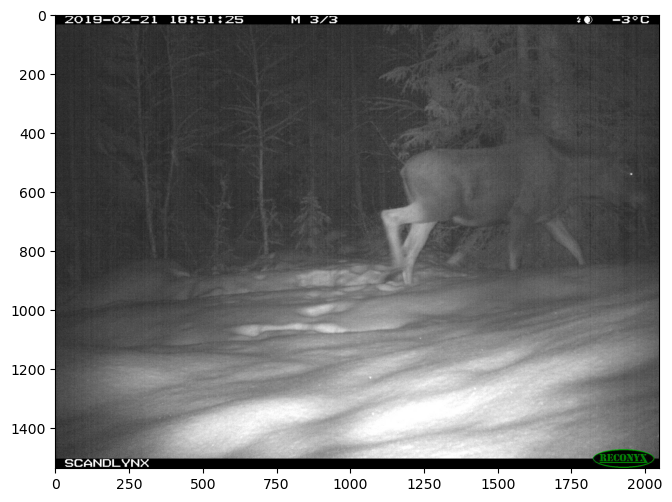

In [139]:
#show_images(inputImages['snow'])

## Rain Image Examples

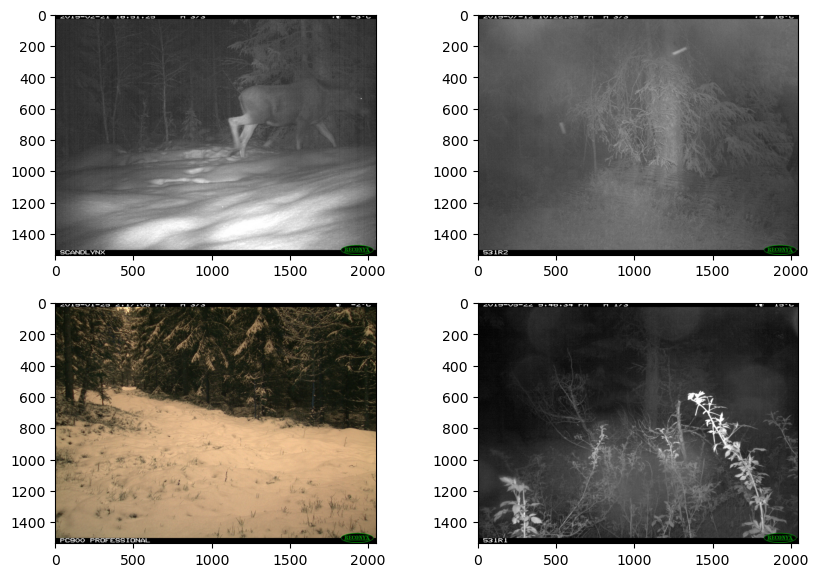

In [29]:
show_images(inputImages['rain'])

## Fog Image Examples

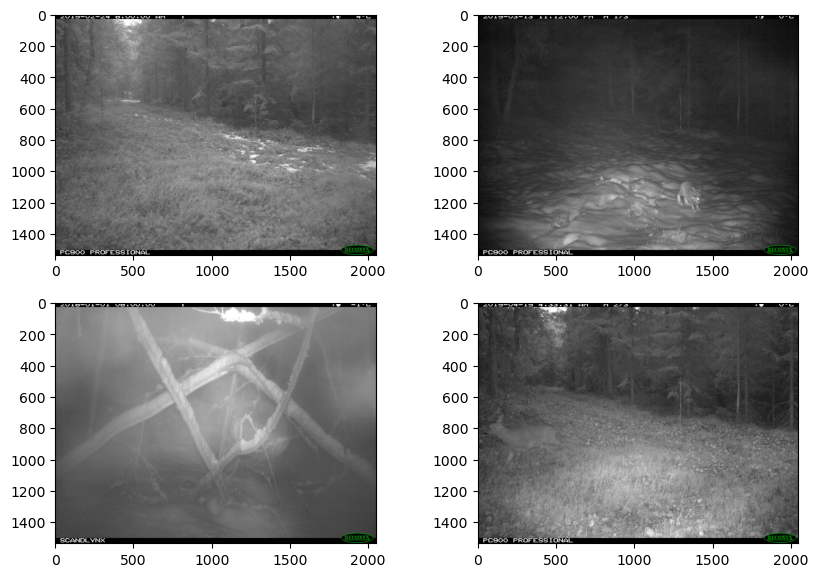

In [30]:
show_images(inputImages['fog'])

## 'None' (i.e. no weather) Image Examples

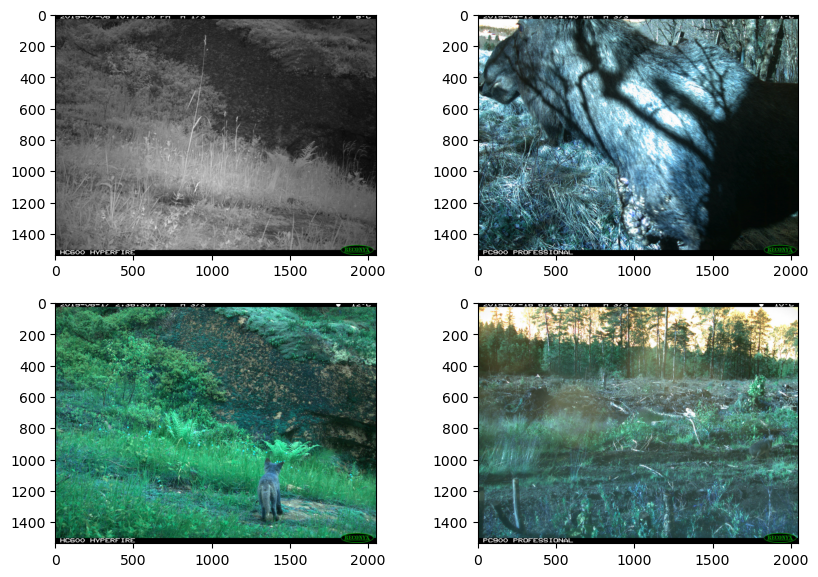

In [31]:
show_images(inputImages['none'])

## 'Other'  Image Examples

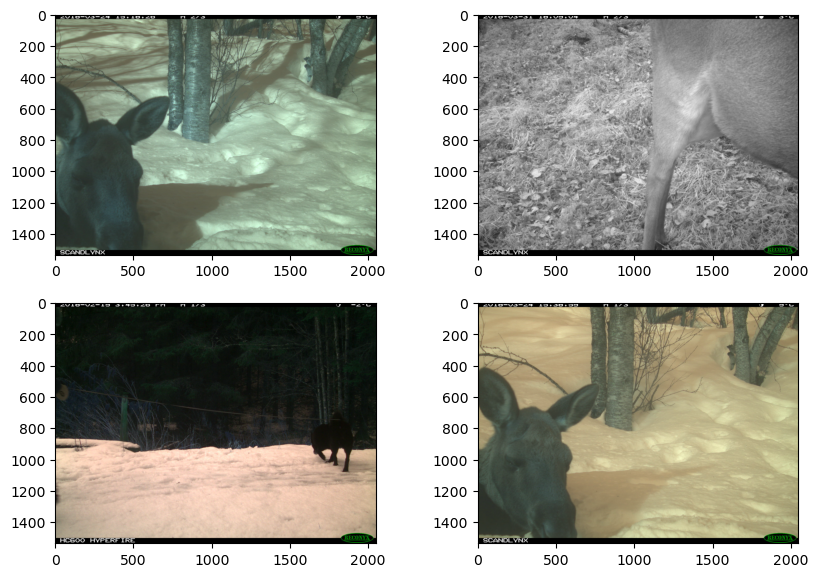

In [97]:
show_images(inputImages['other'])

## Sequences

One thing I want to learn how to do (because I don't yet!) is how to build in logic that takes into account time. I will preview by looking through the data file and find a weather image (1 for rain and 1 for snow) and whether there are any images from the day before or the day after. If that time step doesn't work, I will increase the time step to 2 days and so on. 

I will visualize twos sequences: 
1. None, Rain, None (but snow decreases) 
2. None, Snow, None (but snow decreases)

The example will demonstrate how we may be able to use before and after pictures to influence model accuracy 

In [32]:
def sequenceLookup(date, location):
    ## subset dataframe of location
    cameraIDsubset = data[data['location'] == location]
    timestamp = pd.to_datetime(date)
    
    ## turn date column into datetime column to be able to find time deltas
    times = pd.to_datetime(cameraIDsubset['Date'])
    files = cameraIDsubset['File']
    
    before = []
    after = []
    sequence = []
    ## find all the images that are close to it in time
    for (file, t) in zip(files, times):
        difference = timestamp - t
        diff = difference.total_seconds()  #days
        if abs(diff) <= 100000: ### a little bit more than the number of seconds in a day
            if diff > 0: before.append(file)
            else: after.append(file)
    
    #dictionary.update({filename: sequence})

    after = sorted(after)
    before = sorted(before)
    
    return {filename:[before,after]}
   
    ##### find if any of those images are at that same camera 

### Sequence lookup 

This will create a dictionary of images of interest. The keys will be weather images for snow or rain. The values will be images right before or right after. In this case we set the time delta as 100,000 or a little bit more than the number of seconds in a day. 

Above, we defined sequenceLookup to look up the images that are at the camera around the same day.

In [33]:
#sequenceLookup(date = date, location = location)

In [34]:
rainSequences = {}
snowSequences = {}

for file in glob.glob(norwayPath + str("*")): ## this crashes when run locally 
    if os.path.splitext(file)[1].lower() in ('.jpg', '.jpeg'):
        filename = file.split('/')[-1]
        index = data[data['File'] == filename].index
        weather = (data['Weather'][index].values.tolist())[0]
        date =  (data['Date'][index].values.tolist())[0]
        location = (data['location'][index].values.tolist())[0]
        if (weather == 'Snow'): 
            snowSequences.update(sequenceLookup(date = date, location = location))
        elif (weather == 'Rain'):
            rainSequences.update(sequenceLookup(date = date, location = location))

In [35]:
print('High-level sequence statistics:\n')

print('Rain Sequences: '+str(len(rainSequences)))
print('Snow Sequences: '+str(len(snowSequences)))

High-level sequence statistics:

Rain Sequences: 78
Snow Sequences: 305


High-level sequence statistics:

Rain Sequences: 78
Snow Sequences: 305

Text(0.5, 1.0, 'after')

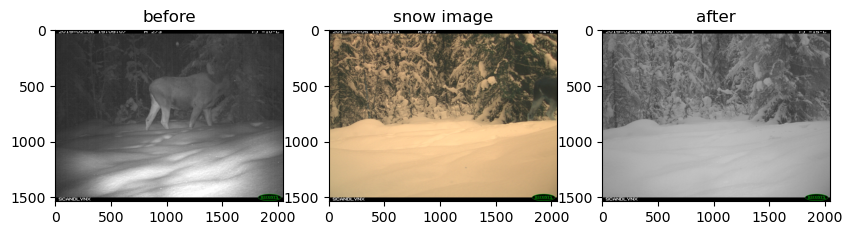

In [36]:
## preview sequences

image = list(snowSequences.keys())[0]
before = list(snowSequences.values())[0][0][-1] ## image right before image of interest
after = list(snowSequences.values())[0][1][0] ## image right after image of interest

fig = plt.figure(figsize=(10, 7))
rows = 1
columns = 3

fig.add_subplot(rows, columns, 1)
plt.imshow(cv2.imread(norwayPath + image))
plt.title('before')

fig.add_subplot(rows, columns, 2)
plt.imshow(cv2.imread(norwayPath + before))
plt.title('snow image')

fig.add_subplot(rows, columns, 3)
plt.imshow(cv2.imread(norwayPath + after))
plt.title('after')


Text(0.5, 1.0, 'after')

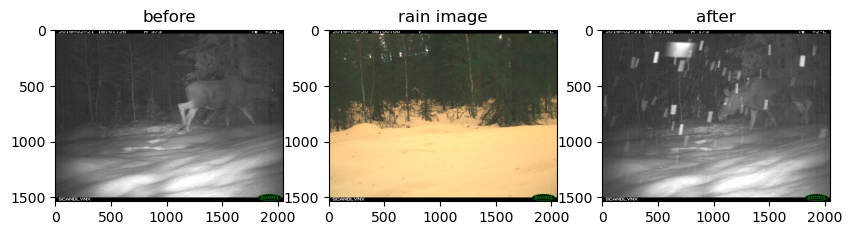

In [37]:
## preview sequences

image = list(rainSequences.keys())[0]
before = list(rainSequences.values())[0][0][-1] ## image right before image of interest
after = list(rainSequences.values())[0][1][0] ## image right after image of interest

fig = plt.figure(figsize=(10, 7))
rows = 1
columns = 3

fig.add_subplot(rows, columns, 1)
plt.imshow(cv2.imread(norwayPath + image))
plt.title('before')

fig.add_subplot(rows, columns, 2)
plt.imshow(cv2.imread(norwayPath + before))
plt.title('rain image')

fig.add_subplot(rows, columns, 3)
plt.imshow(cv2.imread(norwayPath + after))
plt.title('after')



Text(0.5, 1.0, 'after')

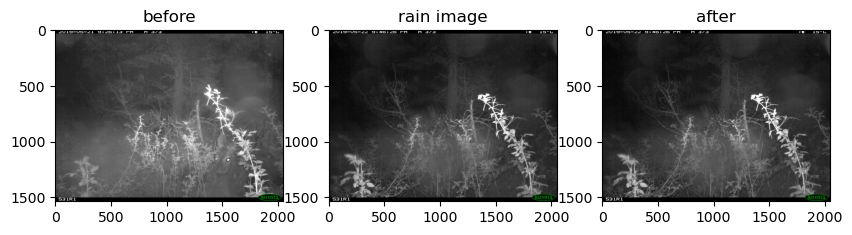

In [70]:
## preview sequences

image = list(rainSequences.keys())[12]
before = list(rainSequences.values())[12][0][-1] ## image right before image of interest
after = list(rainSequences.values())[12][1][0] ## image right after image of interest

fig = plt.figure(figsize=(10, 7))
rows = 1
columns = 3

fig.add_subplot(rows, columns, 1)
plt.imshow(cv2.imread(norwayPath + before))
plt.title('before')

fig.add_subplot(rows, columns, 2)
plt.imshow(cv2.imread(norwayPath + image))
plt.title('rain image')

fig.add_subplot(rows, columns, 3)
plt.imshow(cv2.imread(norwayPath + after))
plt.title('after')



Text(0.5, 1.0, 'after')

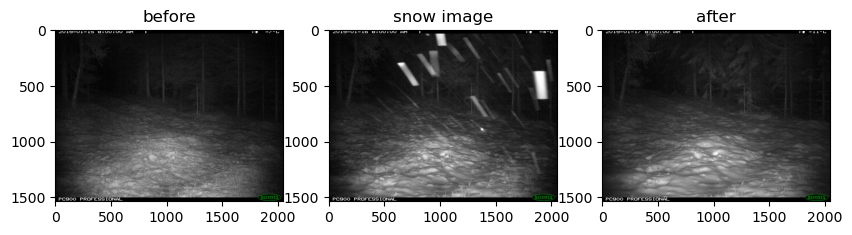

In [78]:
## preview sequences

image = list(snowSequences.keys())[14]
before = list(snowSequences.values())[14][0][-1] ## image right before image of interest
after = list(snowSequences.values())[14][1][1] ## image right after image of interest

fig = plt.figure(figsize=(10, 7))
rows = 1
columns = 3

fig.add_subplot(rows, columns, 1)
plt.imshow(cv2.imread(norwayPath + before))
plt.title('before')

fig.add_subplot(rows, columns, 2)
plt.imshow(cv2.imread(norwayPath + image))
plt.title('snow image')

fig.add_subplot(rows, columns, 3)
plt.imshow(cv2.imread(norwayPath + after))
plt.title('after')




# Takeaways

Still some noise, still need bigger sample size.

To do items: 

- build more sequences
- have more weather images
- have more weather images from certain cameras
- organize images into folders and quality control for final check
- add elevation data with latitude & longitude 

## other ideas

- reweighting the data that you get correct (because those might possibly to detect easier images). This is also called boosting
